# oviIN in comparison to other neurons in the fly brain
We study where  oviIN ranks in terms of number of synpatic partners, number of synaptic sites (pre and post), and number of neuropils it connects to. 
We consider all the traced, uncropped neurons for this study from Hemibrain v1.2. 

In [3]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np

from neuprint import Client
from neuprint import fetch_simple_connections
from neuprint import fetch_neurons, NeuronCriteria as NC


import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'MacOSX', etc.
import matplotlib.pyplot as plt
%matplotlib inline

# Set 'pdf.fonttype' to 42 to keep the text editable after exporting to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

load_dotenv()

True

In [7]:
import warnings
warnings.filterwarnings("ignore")

## Initialise the neuprint client

In [4]:
c = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=os.environ['NEUPRINT_TOKEN']) 
c.fetch_version()


'0.1.0'

In [5]:
# body IDs of oviINs from Neuprint
oviINr_bodyID = 423101189
oviINl_bodyID = 485934965

We fetch all the traced uncropped neurons and make a dataframe for further analysis. Without these criteria, there are 186,061 bodyIds which are probably mostly flotsom but it's good to know that we can mess with those if we want.

In [8]:
# read the traced neurons df for Hemibrain v1.2
df, _ = fetch_neurons(NC(status='Traced', cropped=False))
df

,bodyId,instance,type,pre,post,downstream,upstream,mito,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
0,200326126,CL141_L,CL141,395,1068,4802,1068,274,827930581,Traced,False,Roughly traced,PDL20,251.0,"[3844, 14565, 15568]","{'SNP(R)': {'pre': 17, 'post': 19, 'downstream...",None,"[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","[AVLP(R), ICL(R), INP, LH(R), MB(+ACA)(R), PLP..."
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,776,431,84,235674230,Traced,False,Roughly traced,PDM03,301.0,"[20091, 12266, 12208]","{'SNP(L)': {'pre': 93, 'post': 35, 'downstream...",FB267SMP,"[CX, FB, FB-column3, FBl1, FBl2, FBl3, FBl4, F...","[CX, FB, FBl7, SMP(L), SNP(L)]"
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,426,366,45,154283963,Traced,False,Roughly traced,PDM03,236.0,"[17809, 10233, 14208]","{'SNP(L)': {'pre': 52, 'post': 30, 'downstream...",FB38ABSMP,"[AB(R), CRE(-RUB)(L), CRE(L), CX, FB, FB-colum...","[AB(R), CX, FB, FB-column3, FBl1, FBl7, FBl8, ..."
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,3195,3112,476,1763416504,Traced,False,Roughly traced,None,351.0,"[32168, 13757, 13336]","{'SNP(L)': {'pre': 150, 'post': 2282, 'downstr...",None,"[ATL(L), CRE(-RUB)(L), CRE(L), ICL(L), INP, SC...","[SIP(L), SIP(R), SLP(R), SMP(L), SMP(R), SNP(L..."
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,496,270,65,209983364,Traced,False,Roughly traced,PDM02,301.0,"[22758, 16749, 10240]","{'SNP(L)': {'pre': 65, 'post': 36, 'downstream...",FB267SMP,"[CX, FB, FBl1, FBl2, FBl3, FBl4, FBl5, FBl6, F...","[SIP(L), SMP(L), SNP(L)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633,2503,633,164,462394896,Traced,False,Roughly traced,None,301.5,"[7883, 23524, 33072]","{'OL(R)': {'pre': 268, 'post': 594, 'downstrea...",None,"[LO(R), OL(R), PLP(R), VLNP(R)]","[LO(R), OL(R), PLP(R), VLNP(R)]"
21735,7112615127,AVLP335_R,AVLP335,362,577,2666,577,157,453081149,Traced,False,Roughly traced,AVL13,NaN,None,"{'VLNP(R)': {'pre': 362, 'post': 577, 'downstr...",None,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]"
21736,7112617294,AVLP331_R,AVLP331,285,661,2080,661,137,438751734,Traced,False,Roughly traced,AVL13,NaN,None,"{'VLNP(R)': {'pre': 285, 'post': 661, 'downstr...",None,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]"
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087,11635,2087,534,1529252938,Traced,False,Roughly traced,None,NaN,None,"{'SNP(R)': {'pre': 304, 'post': 130, 'downstre...",VeLC-(LC)(c)Sm(b),"[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...","[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(..."


## Size
We study size of every neuron in the brain listed in descending order and where oviIn stands

In [9]:
size_neurons = df[['bodyId','instance','size','somaRadius']].sort_values(by='size',ascending=False,ignore_index=True).copy()
size_neurons.head(20)

,bodyId,instance,size,somaRadius
0,5813050455,DNp32_R,25280916792,1341.0
1,425790257,APL_R,23360457066,900.1
2,1072063538,DNp27_R,16654541697,646.0
3,5813105172,DPM_R,15191654896,681.0
4,1807537598,HSE LPTC,12790165356,840.5
5,2124762952,mALC2_L,12642223789,241.5
6,1497973422,AMMC-A1_R,12500596539,365.0
7,262840563,OCG01,12489936696,486.0
8,5813070019,AMMC-A1_R,11740731985,645.5
9,1311993208,CT1_L,11629295267,945.0


We observe that oviIN is not the largest neuron but it ranks as the 16th largest out of 21,739 so it is up there. APL is 2nd largest, lLN2f_bs are 18th and 19th largest. The right DPM is 4th largest.

In [10]:
size_neurons.loc[size_neurons['bodyId']==oviINr_bodyID]

,bodyId,instance,size,somaRadius
15,423101189,oviIN_R,10033593370,NaN


Plotting the trends and distribution of sizes for neurons

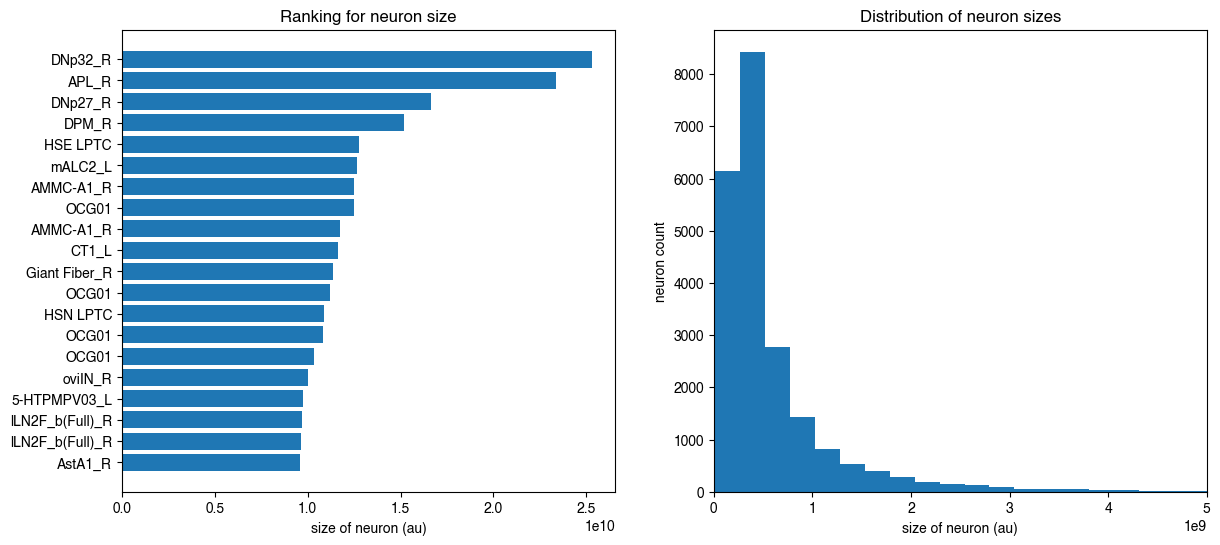

In [11]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(size_neurons.head(nn)))
performance = size_neurons['size'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=size_neurons['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('size of neuron (au)')
ax[0].set_title('Ranking for neuron size')

ax[1].hist(size_neurons['size'],bins=100)
ax[1].set_xlabel('size of neuron (au)')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of neuron sizes')
ax[1].set_xlim(0,0.5e10)

plt.show()

We also observe that oviIN's soma radius is not available in the current data.

In [12]:
somaSize = size_neurons.sort_values(by='somaRadius',ascending=False,ignore_index=True)
somaSize.loc[somaSize['bodyId']==oviINr_bodyID]

,bodyId,instance,size,somaRadius
16804,423101189,oviIN_R,10033593370,NaN


In [13]:
somaSize.head(10)

,bodyId,instance,size,somaRadius
0,5813050455,DNp32_R,25280916792,1341.0
1,1575852343,CT1(AVM19)_R,6303385952,1329.0
2,1135837629,DSKMP1A_R,9376851530,1116.0
3,1260833150,DSKMP1A(PVM02)_L,6972520893,1010.5
4,1884625521,l-LNv,3531576662,995.0
5,1714172947,Am1? LOP-LO,2750045253,990.5
6,1352077058,DSKMP1B_R,5492683352,955.0
7,5813027248,aMe17a,4056415219,947.0
8,1311993208,CT1_L,11629295267,945.0
9,425790257,APL_R,23360457066,900.1


# Partners 

## Obtain partner data for all Hemibrain neurons
This section studies the trends in the number of pre and post synaptic partners and cell types for every neuron in the brain.

In [14]:
all_neurons = df[['bodyId','instance','type','pre','post']].copy()

In [15]:
all_neurons

,bodyId,instance,type,pre,post
0,200326126,CL141_L,CL141,395,1068
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366
3,203253253,SMP505(PDM22)_L,SMP505,415,3112
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270
...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633
21735,7112615127,AVLP335_R,AVLP335,362,577
21736,7112617294,AVLP331_R,AVLP331,285,661
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087


Only run the next block for testing the for loop on only 10 neurons.

In [16]:
# for testing a small chunk uncomment the next line to test a small chunk
# all_neurons = all_neurons.head(n=10)
all_neurons

,bodyId,instance,type,pre,post
0,200326126,CL141_L,CL141,395,1068
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366
3,203253253,SMP505(PDM22)_L,SMP505,415,3112
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270
...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633
21735,7112615127,AVLP335_R,AVLP335,362,577
21736,7112617294,AVLP331_R,AVLP331,285,661
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087


For the full dataset, be cognizant that the following code will take a long time to run on all the neurons (~100 minutes).  This was tested on a small chunk of all_neurons and the results were cross-validated with the neuprint site.

In [132]:
from tqdm import tqdm
all_IDs = list(all_neurons['bodyId'])

# note that fetch_simple_connections only returns connections with Traced neurons
# We count the number of partners, number of types in partners and cumulative sum for partners
for bodyID in tqdm(all_IDs):
    # get the pre-syn partners to neuron and count them up
    inputs = fetch_simple_connections(None,bodyID)
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_pre_partners']] = inputs['bodyId_pre'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_pre_types']] = inputs['type_pre'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['input_weights']] = inputs['weight'].sum()
    
    # get the post-syn partners to neuron and count them up
    outputs = fetch_simple_connections(bodyID,None)
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_post_partners']] = outputs['bodyId_post'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_post_types']] = outputs['type_post'].nunique()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['output_weights']] = outputs['weight'].sum()
    
    # combine input and output bodyIDs and count up total unique synaptic partners
    all_partners = pd.concat([inputs['bodyId_pre'],outputs['bodyId_post']])
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_total_partners']] = all_partners.nunique()

    # combine input and output types and count up total unique synaptic partner types
    all_types = pd.concat([inputs['type_pre'],outputs['type_post']])
    all_neurons.loc[all_neurons['bodyId']==bodyID,['n_total_types']] = all_types.nunique()
    # combine them
    #combine input and output weights and count up total synaptic weights
    all_weights = inputs['weight'].sum() + outputs['weight'].sum()
    all_neurons.loc[all_neurons['bodyId']==bodyID,['total_weights']] = all_weights

all_neurons

  1%|          | 245/21739 [01:45<2:24:22,  2.48it/s]/var/folders/kf/gqzm_ss959z285pynszj514h0000gn/T/ipykernel_81407/3830915253.py:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_partners = pd.concat([inputs['bodyId_pre'],outputs['bodyId_post']])
  2%|▏         | 467/21739 [03:18<2:23:30,  2.47it/s]/var/folders/kf/gqzm_ss959z285pynszj514h0000gn/T/ipykernel_81407/3830915253.py:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_partners = pd.concat([inputs['bodyId_pre'],outputs['bodyId_post']])
  8%|▊         | 1835/21739 [12:57<2:17:05,  2.42it/

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,200326126,CL141_L,CL141,395,1068,331.0,215.0,987.0,450.0,303.0,1262.0,681.0,424.0,2249.0
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,172.0,82.0,389.0,144.0,31.0,430.0,301.0,104.0,819.0
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,157.0,62.0,336.0,104.0,27.0,231.0,230.0,69.0,567.0
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,688.0,143.0,2926.0,322.0,123.0,1100.0,904.0,218.0,4026.0
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,124.0,57.0,248.0,93.0,21.0,262.0,202.0,68.0,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633,315.0,44.0,578.0,300.0,77.0,633.0,536.0,100.0,1211.0
21735,7112615127,AVLP335_R,AVLP335,362,577,183.0,110.0,521.0,176.0,118.0,475.0,331.0,200.0,996.0
21736,7112617294,AVLP331_R,AVLP331,285,661,232.0,119.0,605.0,158.0,113.0,417.0,355.0,198.0,1022.0
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087,506.0,188.0,1947.0,746.0,290.0,4173.0,1082.0,360.0,6120.0


In [133]:
# replace None with string
all_neurons = all_neurons.fillna('None')
all_neurons

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,200326126,CL141_L,CL141,395,1068,331.0,215.0,987.0,450.0,303.0,1262.0,681.0,424.0,2249.0
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,172.0,82.0,389.0,144.0,31.0,430.0,301.0,104.0,819.0
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,157.0,62.0,336.0,104.0,27.0,231.0,230.0,69.0,567.0
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,688.0,143.0,2926.0,322.0,123.0,1100.0,904.0,218.0,4026.0
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,124.0,57.0,248.0,93.0,21.0,262.0,202.0,68.0,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633,315.0,44.0,578.0,300.0,77.0,633.0,536.0,100.0,1211.0
21735,7112615127,AVLP335_R,AVLP335,362,577,183.0,110.0,521.0,176.0,118.0,475.0,331.0,200.0,996.0
21736,7112617294,AVLP331_R,AVLP331,285,661,232.0,119.0,605.0,158.0,113.0,417.0,355.0,198.0,1022.0
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087,506.0,188.0,1947.0,746.0,290.0,4173.0,1082.0,360.0,6120.0


In [135]:
# save this in the oviIN_specs folder
all_neurons.to_csv('data/all_neurons_n_partners.csv')

In [17]:
# to load the saved dataframe of all_neurons
all_neurons = pd.read_csv('data/all_neurons_n_partners.csv', index_col=0)
all_neurons

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,200326126,CL141_L,CL141,395,1068,331.0,215.0,987.0,450.0,303.0,1262.0,681.0,424.0,2249.0
1,202916528,FS4C(FQ12)_C4_R,FS4C,95,431,172.0,82.0,389.0,144.0,31.0,430.0,301.0,104.0,819.0
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,62,366,157.0,62.0,336.0,104.0,27.0,231.0,230.0,69.0,567.0
3,203253253,SMP505(PDM22)_L,SMP505,415,3112,688.0,143.0,2926.0,322.0,123.0,1100.0,904.0,218.0,4026.0
4,203257652,FS4C(FQ12)_C6_R,FS4C,65,270,124.0,57.0,248.0,93.0,21.0,262.0,202.0,68.0,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,319,633,315.0,44.0,578.0,300.0,77.0,633.0,536.0,100.0,1211.0
21735,7112615127,AVLP335_R,AVLP335,362,577,183.0,110.0,521.0,176.0,118.0,475.0,331.0,200.0,996.0
21736,7112617294,AVLP331_R,AVLP331,285,661,232.0,119.0,605.0,158.0,113.0,417.0,355.0,198.0,1022.0
21737,7112622044,LAL137(PVL05)_L,LAL137,1376,2087,506.0,188.0,1947.0,746.0,290.0,4173.0,1082.0,360.0,6120.0


## Synaptic partner rankings for quantity of neurons and types
### Ranking for presynaptic partners

We observe that oviIN ranks 14th for the most pre-synaptic partners. APL is 2nd, lLN2F_bs are 4th and 7th, DPM is 15th.

In [18]:
# sorting by the number of pre-synaptic partners and finding where oviIN ranks
pre_partner_rank = all_neurons.sort_values(by='n_pre_partners',ascending=False,ignore_index=True)
pre_partner_rank.loc[pre_partner_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
13,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [19]:
pre_partner_rank.head(15)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,2124762952,mALC2_L,mALC2,7281,20985,4388.0,128.0,19584.0,5011.0,163.0,16871.0,7628.0,187.0,36455.0
1,425790257,APL_R,APL,16190,127151,3146.0,355.0,121329.0,3085.0,362.0,108759.0,3464.0,493.0,230088.0
2,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,3119.0,1080.0,9315.0,6070.0,1997.0,22467.0,6919.0,2121.0,31782.0
3,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,3020.0,240.0,26084.0,3112.0,269.0,28323.0,3714.0,293.0,54407.0
4,425276848,DPM_L,DPM,7088,30007,2997.0,69.0,28391.0,3047.0,135.0,21194.0,3405.0,144.0,49585.0
5,5901218894,lLN2F_a(Full)_R,lLN2F_a,5875,20616,2774.0,228.0,19713.0,2972.0,289.0,18308.0,3573.0,300.0,38021.0
6,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,2748.0,239.0,24806.0,2896.0,272.0,28755.0,3393.0,300.0,53561.0
7,1670287030,lLN2F_a(Full)_R,lLN2F_a,5870,19470,2699.0,229.0,18570.0,2943.0,284.0,17967.0,3498.0,303.0,36537.0
8,1628523730,mALC2_L,mALC1,3022,6724,2679.0,88.0,6149.0,1509.0,74.0,3741.0,3849.0,110.0,9890.0
9,1343403608,LO intrinsic,NaN,3919,13251,2654.0,78.0,12240.0,2042.0,97.0,5858.0,3851.0,114.0,18098.0


In [20]:
# summary stats
pre_partner_rank['n_pre_partners'].describe()

count    21739.000000
mean       215.717742
std        212.699277
min          0.000000
25%         98.000000
50%        166.000000
75%        265.000000
max       4388.000000
Name: n_pre_partners, dtype: float64

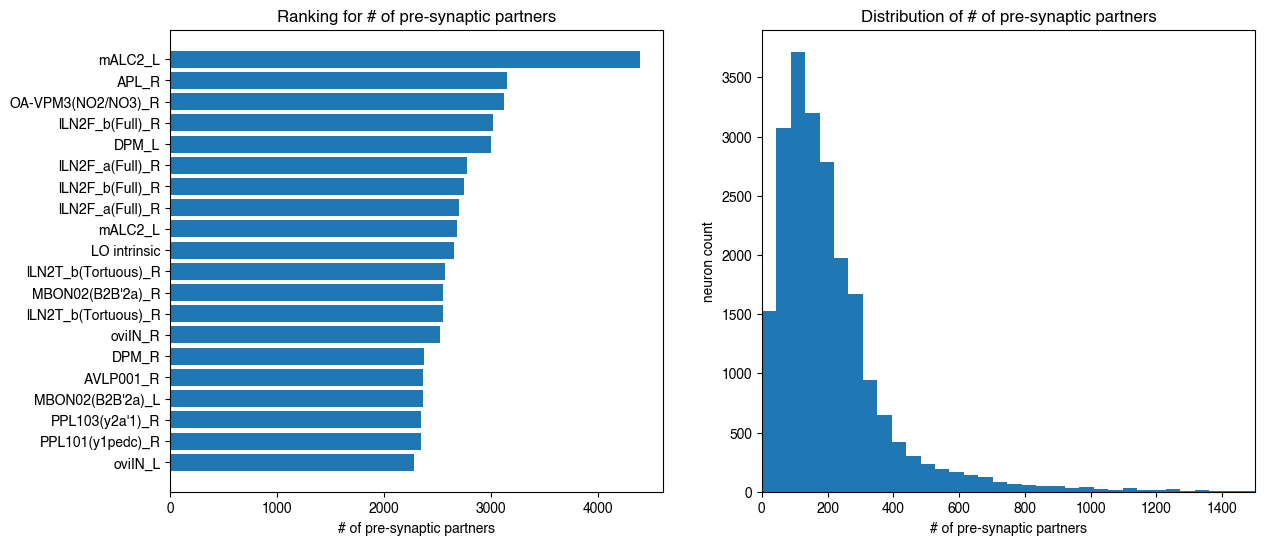

In [21]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(pre_partner_rank.head(nn)))
performance = pre_partner_rank['n_pre_partners'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=pre_partner_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of pre-synaptic partners')
ax[0].set_title('Ranking for # of pre-synaptic partners')

ax[1].hist(pre_partner_rank['n_pre_partners'],bins=100)
ax[1].set_xlabel('# of pre-synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of pre-synaptic partners')
ax[1].set_xlim(0,1500)

plt.show()

### Ranking for postsynaptic partners
We observe that oviINr ranks 10th for the most post-synaptic partners. APL is 16th, lLN2F_bs are 15th and 21st, DPMs are 17th and 24th.

In [22]:
# sorting by the number of post-synaptic partners and finding where oviIN ranks
post_partner_rank = all_neurons.sort_values(by='n_post_partners',ascending=False,ignore_index=True)
post_partner_rank.loc[post_partner_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
9,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [23]:
# rank of APL
post_partner_rank.loc[post_partner_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
15,425790257,APL_R,APL,16190,127151,3146.0,355.0,121329.0,3085.0,362.0,108759.0,3464.0,493.0,230088.0


In [24]:
# rank of llN2F_b
post_partner_rank.loc[post_partner_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
14,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,3020.0,240.0,26084.0,3112.0,269.0,28323.0,3714.0,293.0,54407.0
20,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,2748.0,239.0,24806.0,2896.0,272.0,28755.0,3393.0,300.0,53561.0


In [25]:
# rank of DPM
post_partner_rank.loc[post_partner_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
16,425276848,DPM_L,DPM,7088,30007,2997.0,69.0,28391.0,3047.0,135.0,21194.0,3405.0,144.0,49585.0
23,5813105172,DPM_R,DPM,17628,77269,2372.0,115.0,73542.0,2614.0,221.0,48492.0,2656.0,240.0,122034.0


In [26]:
post_partner_rank.head(15)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,3119.0,1080.0,9315.0,6070.0,1997.0,22467.0,6919.0,2121.0,31782.0
1,2124762952,mALC2_L,mALC2,7281,20985,4388.0,128.0,19584.0,5011.0,163.0,16871.0,7628.0,187.0,36455.0
2,669325882,5-HTPMPV03_R,5-HTPMPV03,5728,5606,2027.0,681.0,5132.0,4692.0,1393.0,9138.0,5599.0,1513.0,14270.0
3,5813064410,PLP030_R,PLP030,4692,5497,2103.0,712.0,5008.0,4326.0,1639.0,7622.0,5305.0,1791.0,12630.0
4,1005857944,PLP031_R,PLP031,4429,5231,2149.0,634.0,4819.0,4066.0,1541.0,6796.0,5165.0,1670.0,11615.0
5,791527493,5-HTPMPV03_L,5-HTPMPV03,4679,4922,1729.0,582.0,4521.0,3772.0,1358.0,7070.0,4591.0,1455.0,11591.0
6,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,1737.0,1009.0,4606.0,3649.0,1987.0,10963.0,4216.0,2153.0,15569.0
7,5813061260,OA-VPM3(NO2/NO3)_L,OA-VPM3,4069,5122,1627.0,565.0,4768.0,3628.0,1134.0,11085.0,4051.0,1213.0,15853.0
8,485934965,oviIN_L,oviIN,6542,15998,2282.0,577.0,15007.0,3519.0,917.0,24806.0,4461.0,1026.0,39813.0
9,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [27]:

# summary stats
post_partner_rank['n_post_partners'].describe()

count    21739.000000
mean       203.719444
std        225.210410
min          0.000000
25%        100.000000
50%        157.000000
75%        238.000000
max       6070.000000
Name: n_post_partners, dtype: float64

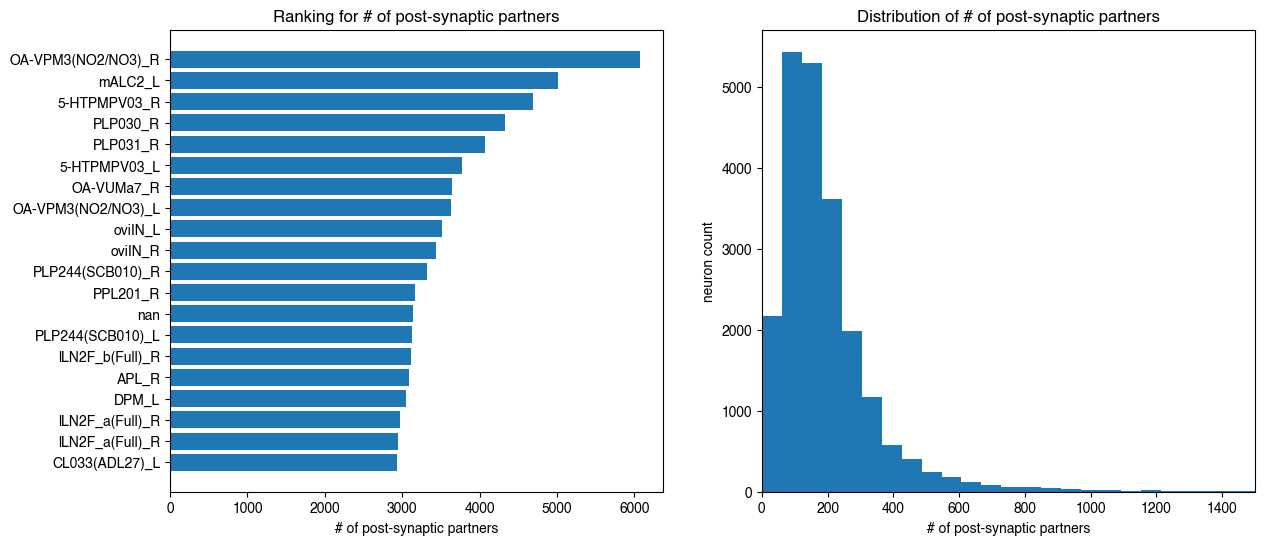

In [28]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(post_partner_rank.head(nn)))
performance = post_partner_rank['n_post_partners'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=post_partner_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of post-synaptic partners')
ax[0].set_title('Ranking for # of post-synaptic partners')

ax[1].hist(post_partner_rank['n_post_partners'],bins=100)
ax[1].set_xlabel('# of post-synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of post-synaptic partners')
ax[1].set_xlim(0,1500)

plt.show()

### Ranking for total number of synaptic partners
We observe that oviINr ranks 7th for total number of unique synaptic partners and oviINl is right behind it. Interestingly, DPM and APL are not in the top ten. APL is 21st, DPMs are 24th and 59th, lLN2F_bs are 16th and 25th. This is striking because it indicates that oviIN is communnicating with a broad range of neurons.

In [29]:
# sorting by the number of total unique synaptic partners and finding where oviIN ranks
total_partner_rank = all_neurons.sort_values(by='n_total_partners',ascending=False,ignore_index=True)
total_partner_rank.loc[total_partner_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
6,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [30]:
total_partner_rank.head(10)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,2124762952,mALC2_L,mALC2,7281,20985,4388.0,128.0,19584.0,5011.0,163.0,16871.0,7628.0,187.0,36455.0
1,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,3119.0,1080.0,9315.0,6070.0,1997.0,22467.0,6919.0,2121.0,31782.0
2,669325882,5-HTPMPV03_R,5-HTPMPV03,5728,5606,2027.0,681.0,5132.0,4692.0,1393.0,9138.0,5599.0,1513.0,14270.0
3,5813064410,PLP030_R,PLP030,4692,5497,2103.0,712.0,5008.0,4326.0,1639.0,7622.0,5305.0,1791.0,12630.0
4,1005857944,PLP031_R,PLP031,4429,5231,2149.0,634.0,4819.0,4066.0,1541.0,6796.0,5165.0,1670.0,11615.0
5,791527493,5-HTPMPV03_L,5-HTPMPV03,4679,4922,1729.0,582.0,4521.0,3772.0,1358.0,7070.0,4591.0,1455.0,11591.0
6,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0
7,485934965,oviIN_L,oviIN,6542,15998,2282.0,577.0,15007.0,3519.0,917.0,24806.0,4461.0,1026.0,39813.0
8,5813061112,PLP244(SCB010)_R,PLP244,3586,3909,1626.0,419.0,3505.0,3325.0,1022.0,6803.0,4220.0,1127.0,10308.0
9,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,1737.0,1009.0,4606.0,3649.0,1987.0,10963.0,4216.0,2153.0,15569.0


In [31]:
# summary stats
total_partner_rank['n_total_partners'].describe()

count    21739.000000
mean       348.892313
std        327.284449
min          2.000000
25%        177.000000
50%        274.000000
75%        413.000000
max       7628.000000
Name: n_total_partners, dtype: float64

In [32]:
total_partner_rank.loc[total_partner_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
15,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,3020.0,240.0,26084.0,3112.0,269.0,28323.0,3714.0,293.0,54407.0
24,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,2748.0,239.0,24806.0,2896.0,272.0,28755.0,3393.0,300.0,53561.0


In [33]:
# compute the average number of synaptic partners per neuron
total_partner_rank.loc[total_partner_rank['type']=='lLN2F_b']['n_total_partners'].mean()

np.float64(3553.5)

In [34]:
# compute the average number of synaptic partner types per neuron
total_partner_rank.loc[total_partner_rank['type']=='lLN2F_b']['n_total_types'].mean()

np.float64(296.5)

In [35]:
total_partner_rank.loc[total_partner_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
20,425790257,APL_R,APL,16190,127151,3146.0,355.0,121329.0,3085.0,362.0,108759.0,3464.0,493.0,230088.0


In [36]:
total_partner_rank.loc[total_partner_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
23,425276848,DPM_L,DPM,7088,30007,2997.0,69.0,28391.0,3047.0,135.0,21194.0,3405.0,144.0,49585.0
58,5813105172,DPM_R,DPM,17628,77269,2372.0,115.0,73542.0,2614.0,221.0,48492.0,2656.0,240.0,122034.0


In [37]:
# compute the average number of synaptic partners per neuron
total_partner_rank.loc[total_partner_rank['type']=='DPM']['n_total_partners'].mean()

np.float64(3030.5)

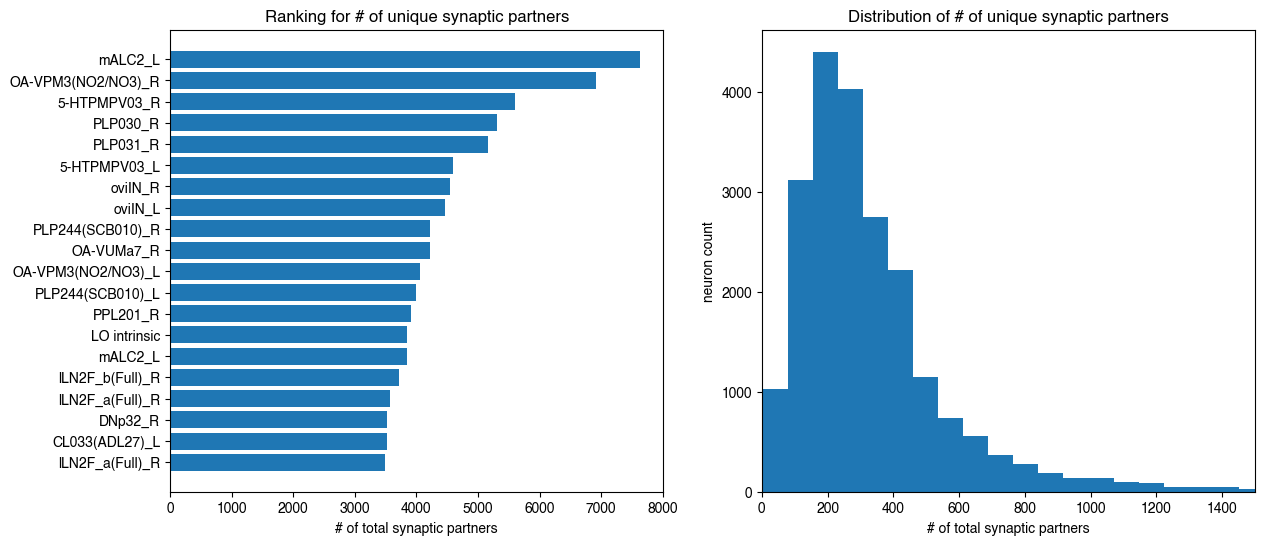

In [38]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_partner_rank.head(nn)))
performance = total_partner_rank['n_total_partners'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=total_partner_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of total synaptic partners')
ax[0].set_title('Ranking for # of unique synaptic partners')

ax[1].hist(total_partner_rank['n_total_partners'],bins=100)
ax[1].set_xlabel('# of total synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of unique synaptic partners')
ax[1].set_xlim(0,1500)

#plt.savefig('figures/total_partners_rank_hbar_hist.pdf', format='pdf')
plt.show()

Following is a combined stacked bar chart for pre and post partners. The stacked horizontal bars are sometimes longer than for the combined unique because here a partner can sometimes be pre and postsynaptic to a given neuron. 

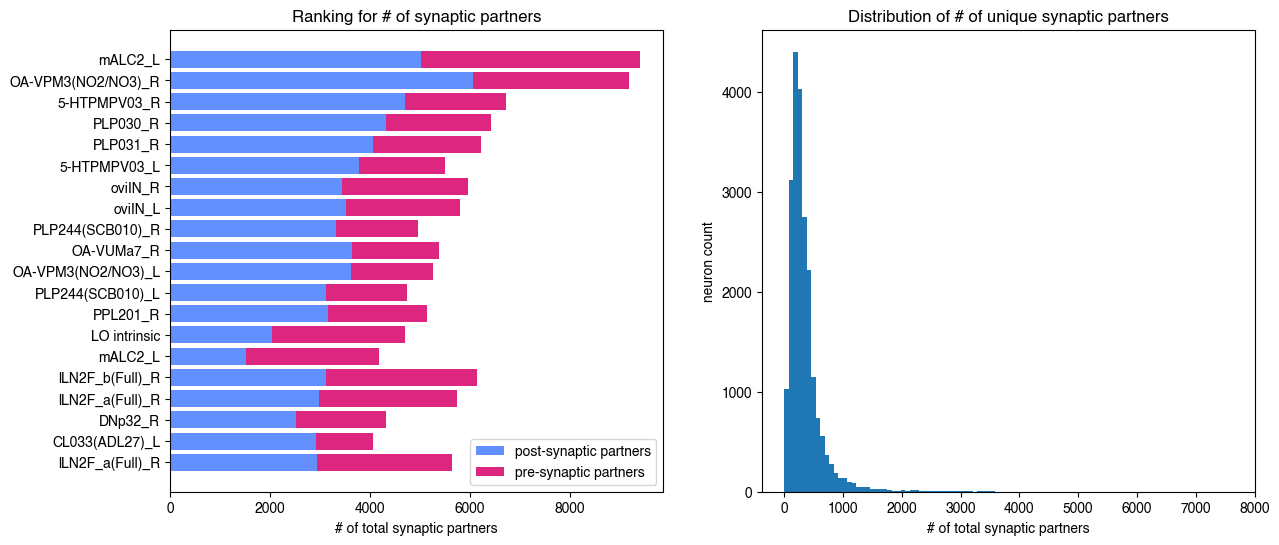

In [39]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_partner_rank.head(nn)))
postp = total_partner_rank['n_post_partners'].head(nn)
prep = total_partner_rank['n_pre_partners'].head(nn)

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax[0].barh(y_pos, postp, align='center', color=colors[0])
ax[0].barh(y_pos, prep, align='center', left=postp, color=colors[1])
ax[0].set_yticks(y_pos, labels=total_partner_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of total synaptic partners')
ax[0].set_title('Ranking for # of synaptic partners')
ax[0].legend(['post-synaptic partners','pre-synaptic partners'])

ax[1].hist(total_partner_rank['n_total_partners'],bins=100)
ax[1].set_xlabel('# of total synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of unique synaptic partners')
#ax[1].set_xlim(0,1500)

#plt.savefig('figures/total_partners_rank_hbar_hist.pdf', format='pdf')
plt.show()

This bar chart takes into account synaptic partners that are both pre and post to the neuron.

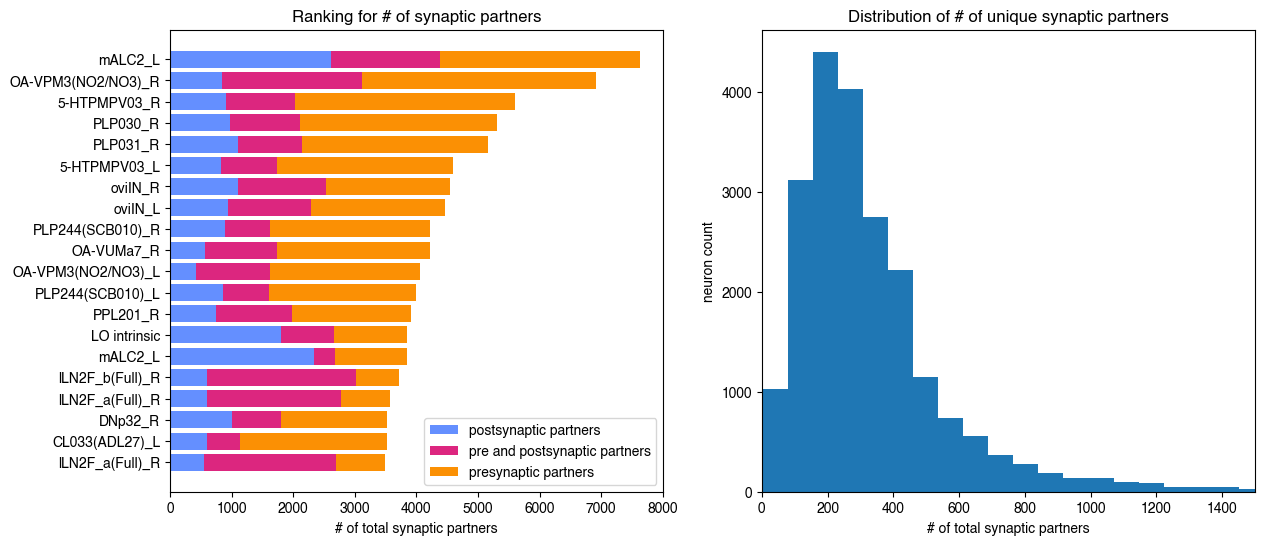

In [40]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_partner_rank.head(nn)))
tuniquep = total_partner_rank['n_total_partners'].head(nn)
postp = total_partner_rank['n_post_partners'].head(nn)
prep = total_partner_rank['n_pre_partners'].head(nn)

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

# calculate the number of double dippers
double_dippers = prep + postp - tuniquep
single_dipper_pre = prep - double_dippers
single_dipper_post = postp - double_dippers

ax[0].barh(y_pos, single_dipper_pre, align='center', color=colors[0])
ax[0].barh(y_pos, double_dippers, align='center', left=single_dipper_pre, color=colors[1])
ax[0].barh(y_pos, single_dipper_post, align='center', left=single_dipper_pre+double_dippers, color=colors[2])
ax[0].set_yticks(y_pos, labels=total_partner_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of total synaptic partners')
ax[0].set_title('Ranking for # of synaptic partners')
ax[0].legend(['postsynaptic partners','pre and postsynaptic partners','presynaptic partners'])

ax[1].hist(total_partner_rank['n_total_partners'],bins=100)
ax[1].set_xlabel('# of total synaptic partners')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of unique synaptic partners')
ax[1].set_xlim(0,1500)

# plt.savefig('figures/total_partners_rank_hbar_hist_stackd.pdf', format='pdf')
plt.show()

### Ranking for number of presynaptic cell types
We observe oviINr ranks 5th for the number of cell types in its pre-synaptic partners. The other neurons don't even come close! APL ranks 337, DPMs rank 5280 and 9555, lLN2F_bs rank 1031 and 1045. 

In [41]:
# sorting by the number of pre-synaptic types and finding where oviIN ranks
pre_type_rank = all_neurons.sort_values(by='n_pre_types',ascending=False,ignore_index=True)
pre_type_rank.loc[pre_type_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
4,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [42]:
pre_type_rank.loc[pre_type_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
335,425790257,APL_R,APL,16190,127151,3146.0,355.0,121329.0,3085.0,362.0,108759.0,3464.0,493.0,230088.0


In [43]:
pre_type_rank.loc[pre_type_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
5274,5813105172,DPM_R,DPM,17628,77269,2372.0,115.0,73542.0,2614.0,221.0,48492.0,2656.0,240.0,122034.0
9533,425276848,DPM_L,DPM,7088,30007,2997.0,69.0,28391.0,3047.0,135.0,21194.0,3405.0,144.0,49585.0


In [44]:
pre_type_rank.loc[pre_type_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1025,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,3020.0,240.0,26084.0,3112.0,269.0,28323.0,3714.0,293.0,54407.0
1045,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,2748.0,239.0,24806.0,2896.0,272.0,28755.0,3393.0,300.0,53561.0


In [45]:
pre_type_rank.head(15)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,328533761,PPL201_R,PPL201,4747,8596,1974.0,1086.0,8077.0,3162.0,1510.0,8922.0,3907.0,1767.0,16999.0
1,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,3119.0,1080.0,9315.0,6070.0,1997.0,22467.0,6919.0,2121.0,31782.0
2,5813050455,DNp32_R,DNp32,3051,6922,1795.0,1047.0,6401.0,2516.0,1583.0,5017.0,3528.0,1963.0,11418.0
3,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,1737.0,1009.0,4606.0,3649.0,1987.0,10963.0,4216.0,2153.0,15569.0
4,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0
5,947573616,AVLP016_R,AVLP016,4740,21382,2190.0,955.0,19962.0,1748.0,896.0,11597.0,3011.0,1243.0,31559.0
6,327499164,LHCENT2_R,LHCENT2,2773,11285,1792.0,910.0,10506.0,1639.0,811.0,6552.0,2575.0,1152.0,17058.0
7,330268940,LHCENT9_R,LHCENT9,2654,12428,1710.0,893.0,11795.0,1732.0,989.0,8370.0,2507.0,1250.0,20165.0
8,487144598,LHCENT3_R,LHCENT3,3049,11419,1866.0,891.0,10816.0,2085.0,995.0,9925.0,3046.0,1327.0,20741.0
9,1321564092,AVLP001_R,AVLP001,4789,17299,2364.0,856.0,15993.0,1896.0,784.0,12646.0,3150.0,1014.0,28639.0


In [46]:
# summary stats
pre_type_rank['n_pre_types'].describe()

count    21739.000000
mean        82.335664
std         85.226453
min          0.000000
25%         25.000000
50%         57.000000
75%        113.000000
max       1086.000000
Name: n_pre_types, dtype: float64

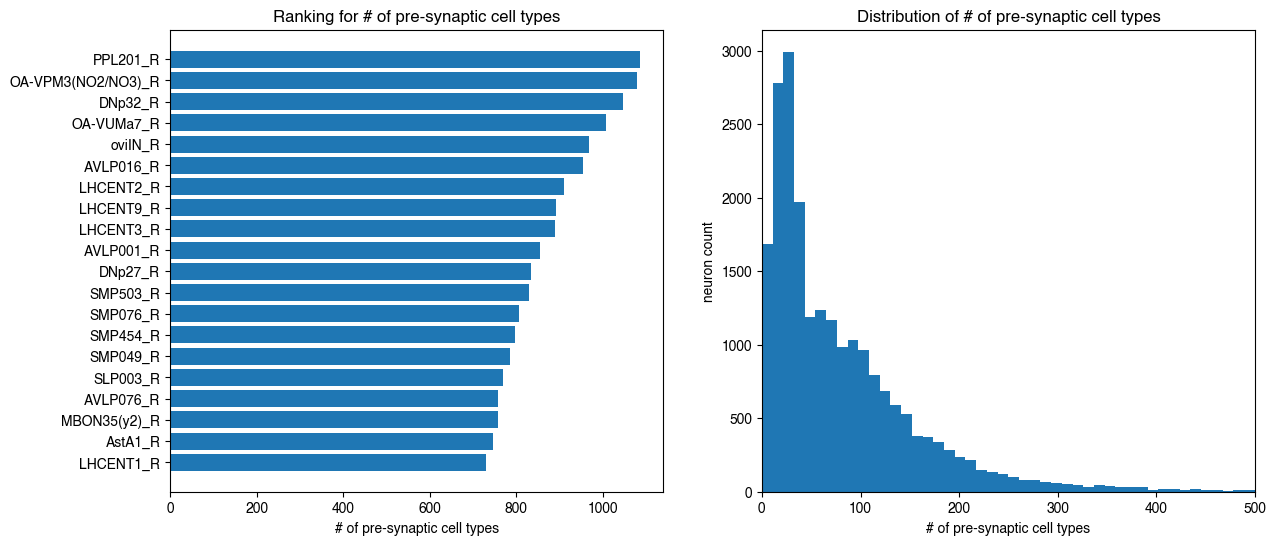

In [47]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(pre_type_rank.head(nn)))
performance = pre_type_rank['n_pre_types'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=pre_type_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of pre-synaptic cell types')
ax[0].set_title('Ranking for # of pre-synaptic cell types')

ax[1].hist(pre_type_rank['n_pre_types'],bins=100)
ax[1].set_xlabel('# of pre-synaptic cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of pre-synaptic cell types')
ax[1].set_xlim(0,500)

plt.show()

### Ranking for number of postsynaptic cell types
We observe that oviINr ranks 23rd for the number of cell types in its post-synaptic partners leaving the others in the dust once again. APL ranks 318, DPMs rank 1229 and 4067, lLN2F_bs rank 704 and 725. 

In [48]:
# sorting by the number of post-synaptic types and finding where oviIN ranks
post_type_rank = all_neurons.sort_values(by='n_post_types',ascending=False,ignore_index=True)
post_type_rank.loc[post_type_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
22,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [49]:
post_type_rank.loc[post_type_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
316,425790257,APL_R,APL,16190,127151,3146.0,355.0,121329.0,3085.0,362.0,108759.0,3464.0,493.0,230088.0


In [50]:
post_type_rank.loc[post_type_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1232,5813105172,DPM_R,DPM,17628,77269,2372.0,115.0,73542.0,2614.0,221.0,48492.0,2656.0,240.0,122034.0
4044,425276848,DPM_L,DPM,7088,30007,2997.0,69.0,28391.0,3047.0,135.0,21194.0,3405.0,144.0,49585.0


In [51]:
post_type_rank.loc[post_type_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
704,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,2748.0,239.0,24806.0,2896.0,272.0,28755.0,3393.0,300.0,53561.0
733,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,3020.0,240.0,26084.0,3112.0,269.0,28323.0,3714.0,293.0,54407.0


In [52]:
post_type_rank.head(30)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,3119.0,1080.0,9315.0,6070.0,1997.0,22467.0,6919.0,2121.0,31782.0
1,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,1737.0,1009.0,4606.0,3649.0,1987.0,10963.0,4216.0,2153.0,15569.0
2,5813064410,PLP030_R,PLP030,4692,5497,2103.0,712.0,5008.0,4326.0,1639.0,7622.0,5305.0,1791.0,12630.0
3,5813050455,DNp32_R,DNp32,3051,6922,1795.0,1047.0,6401.0,2516.0,1583.0,5017.0,3528.0,1963.0,11418.0
4,1005857944,PLP031_R,PLP031,4429,5231,2149.0,634.0,4819.0,4066.0,1541.0,6796.0,5165.0,1670.0,11615.0
5,736860990,OA-VUMa6_R,OA-VUMa6,3294,3109,1118.0,691.0,2855.0,2499.0,1538.0,6512.0,2912.0,1671.0,9367.0
6,1041666949,NaN,NaN,5506,3413,1175.0,617.0,3076.0,3140.0,1518.0,11208.0,3462.0,1598.0,14284.0
7,328533761,PPL201_R,PPL201,4747,8596,1974.0,1086.0,8077.0,3162.0,1510.0,8922.0,3907.0,1767.0,16999.0
8,669325882,5-HTPMPV03_R,5-HTPMPV03,5728,5606,2027.0,681.0,5132.0,4692.0,1393.0,9138.0,5599.0,1513.0,14270.0
9,791527493,5-HTPMPV03_L,5-HTPMPV03,4679,4922,1729.0,582.0,4521.0,3772.0,1358.0,7070.0,4591.0,1455.0,11591.0


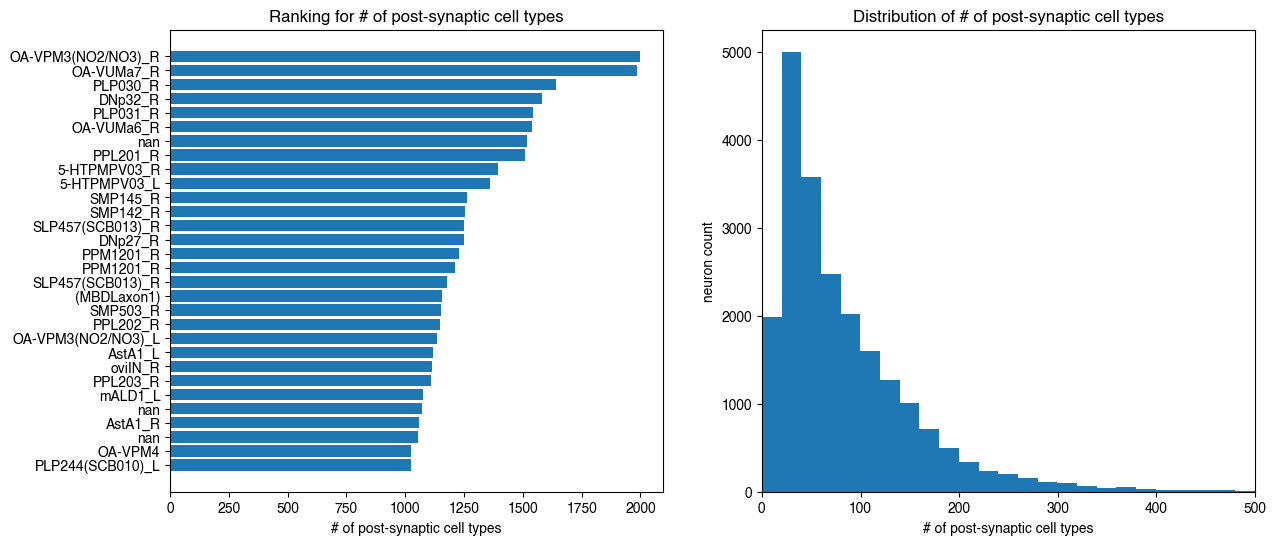

In [53]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 30

# grab the data
y_pos = np.arange(len(post_type_rank.head(nn)))
performance = post_type_rank['n_post_types'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=post_type_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of post-synaptic cell types')
ax[0].set_title('Ranking for # of post-synaptic cell types')

ax[1].hist(post_type_rank['n_post_types'],bins=100)
ax[1].set_xlabel('# of post-synaptic cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of # of post-synaptic cell types')
ax[1].set_xlim(0,500)

plt.show()

### Ranking for total number of partnering cell types
We observe that oviINr ranks 15th for the total number of cell types that it makes direct connections with. APL ranks 442, DPMs rank 3452 and 8164, lLN2F_bs rank 1880 and 1993. Including the 'None' types here is valid since the ranking is on an individual neuron basis. There is a None neuron in here that just happens to rank 8th in terms of number of partnering cell types. 

In [54]:
# sorting by the number of total unique synaptic partners types and finding where oviIN ranks
total_type_rank = all_neurons.sort_values(by='n_total_types',ascending=False,ignore_index=True)

In [55]:
total_type_rank.loc[total_type_rank['bodyId']==oviINr_bodyID]

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
14,423101189,oviIN_R,oviIN,6863,23029,2524.0,968.0,21624.0,3441.0,1112.0,29274.0,4548.0,1379.0,50898.0


In [56]:
total_type_rank.loc[total_type_rank['type']=='APL']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
441,425790257,APL_R,APL,16190,127151,3146.0,355.0,121329.0,3085.0,362.0,108759.0,3464.0,493.0,230088.0


In [57]:
total_type_rank.loc[total_type_rank['type']=='DPM']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
3436,5813105172,DPM_R,DPM,17628,77269,2372.0,115.0,73542.0,2614.0,221.0,48492.0,2656.0,240.0,122034.0
8152,425276848,DPM_L,DPM,7088,30007,2997.0,69.0,28391.0,3047.0,135.0,21194.0,3405.0,144.0,49585.0


In [58]:
total_type_rank.loc[total_type_rank['type']=='DPM']['n_total_types'].mean()

np.float64(192.0)

In [59]:
total_type_rank.loc[total_type_rank['type']=='lLN2F_b']

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
1878,5813024698,lLN2F_b(Full)_R,lLN2F_b,8152,26039,2748.0,239.0,24806.0,2896.0,272.0,28755.0,3393.0,300.0,53561.0
1993,1640909284,lLN2F_b(Full)_R,lLN2F_b,7998,27355,3020.0,240.0,26084.0,3112.0,269.0,28323.0,3714.0,293.0,54407.0


In [60]:
total_type_rank.loc[total_type_rank['type']=='lLN2F_b']['n_total_types'].mean()

np.float64(296.5)

In [61]:
total_type_rank.head(16)

,bodyId,instance,type,pre,post,n_pre_partners,n_pre_types,input_weights,n_post_partners,n_post_types,output_weights,n_total_partners,n_total_types,total_weights
0,576825965,OA-VUMa7_R,OA-VUMa7,5253,4992,1737.0,1009.0,4606.0,3649.0,1987.0,10963.0,4216.0,2153.0,15569.0
1,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,8632,10075,3119.0,1080.0,9315.0,6070.0,1997.0,22467.0,6919.0,2121.0,31782.0
2,5813050455,DNp32_R,DNp32,3051,6922,1795.0,1047.0,6401.0,2516.0,1583.0,5017.0,3528.0,1963.0,11418.0
3,5813064410,PLP030_R,PLP030,4692,5497,2103.0,712.0,5008.0,4326.0,1639.0,7622.0,5305.0,1791.0,12630.0
4,328533761,PPL201_R,PPL201,4747,8596,1974.0,1086.0,8077.0,3162.0,1510.0,8922.0,3907.0,1767.0,16999.0
5,736860990,OA-VUMa6_R,OA-VUMa6,3294,3109,1118.0,691.0,2855.0,2499.0,1538.0,6512.0,2912.0,1671.0,9367.0
6,1005857944,PLP031_R,PLP031,4429,5231,2149.0,634.0,4819.0,4066.0,1541.0,6796.0,5165.0,1670.0,11615.0
7,1041666949,NaN,NaN,5506,3413,1175.0,617.0,3076.0,3140.0,1518.0,11208.0,3462.0,1598.0,14284.0
8,1072063538,DNp27_R,DNp27,2658,6792,1614.0,834.0,6322.0,2449.0,1248.0,4616.0,3342.0,1551.0,10938.0
9,669325882,5-HTPMPV03_R,5-HTPMPV03,5728,5606,2027.0,681.0,5132.0,4692.0,1393.0,9138.0,5599.0,1513.0,14270.0


In [62]:
# mean number of total synaptic partner types among all neurons
total_type_rank['n_total_types'].mean()

np.float64(139.17135102810616)

In [63]:
# mode of the number of total synaptic partner types among all neurons
total_type_rank['n_total_types'].mode()

0    36.0
Name: n_total_types, dtype: float64

In [64]:
# summary stats
total_type_rank['n_total_types'].describe()

count    21739.000000
mean       139.171351
std        134.693710
min          0.000000
25%         48.000000
50%        101.000000
75%        191.000000
max       2153.000000
Name: n_total_types, dtype: float64

In [65]:
total_type_rank['n_total_types'].mode()

0    36.0
Name: n_total_types, dtype: float64

In [66]:
total_type_rank['n_total_types'].median()

np.float64(101.0)

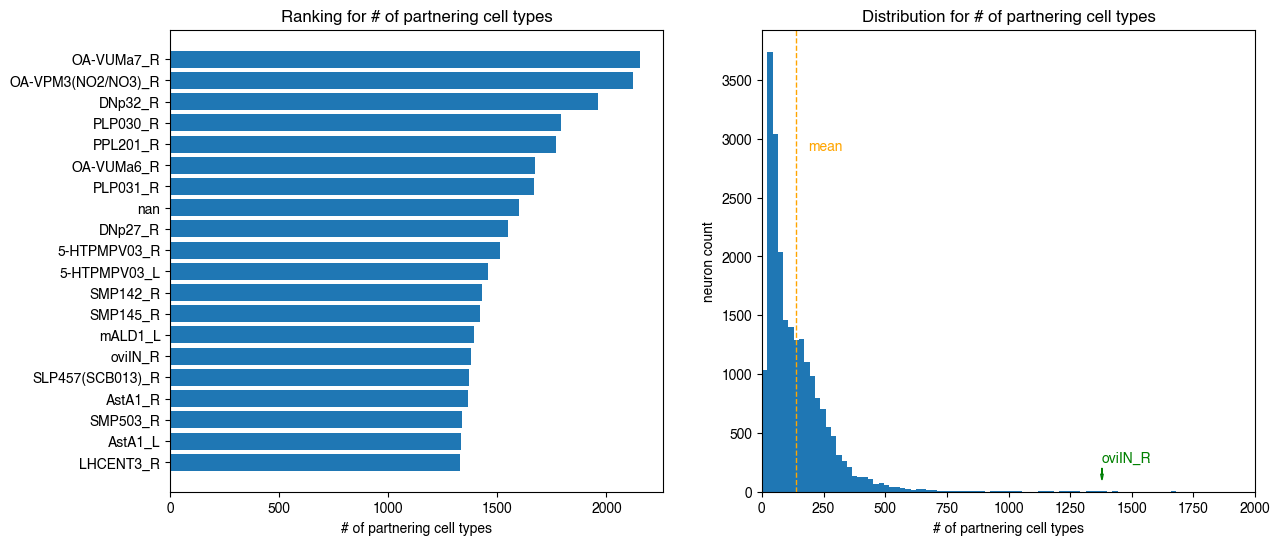

In [67]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_type_rank.head(nn)))
performance = total_type_rank['n_total_types'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=total_type_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of partnering cell types')
ax[0].set_title('Ranking for # of partnering cell types')

ax[1].hist(total_type_rank['n_total_types'],bins=100)
ax[1].set_xlabel('# of partnering cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution for # of partnering cell types')
ax[1].set_xlim(0,2000)

ax[1].axvline(total_type_rank['n_total_types'].mean(), color='orange', linestyle='dashed', linewidth=1)
ax[1].annotate('mean', xy=(total_type_rank['n_total_types'].mean()+50, 2900), color='orange')
# put an arrow where oviIN is
ax[1].arrow(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 250), color='green')

#plt.savefig('figures/total_types_rank_hbar_hist.pdf', format='pdf')
plt.show()

Following is a stacked bar chart to show pre and post types. Since some cell types can be both pre and post, those are depicted as a 3rd color. 

n_pre_types + n_post_types - n_total_types = the double dippers

The double dippers should be subtracted off the n_pre_types and n_post_types to give non-overlapping pre and post types.

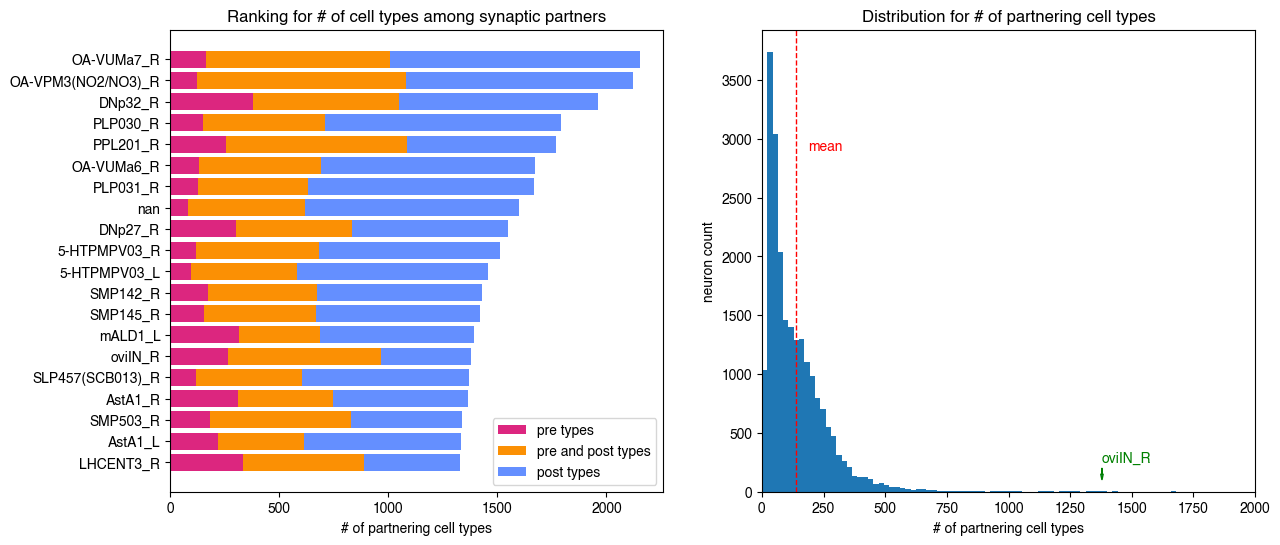

In [68]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(total_type_rank.head(nn)))
tuniquet = total_type_rank['n_total_types'].head(nn)
pret = total_type_rank['n_pre_types'].head(nn)
postt = total_type_rank['n_post_types'].head(nn)

# calculate the number of double dippers
double_dippers = pret + postt - tuniquet
single_dipper_pre = pret - double_dippers
single_dipper_post = postt - double_dippers

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax[0].barh(y_pos, single_dipper_pre, align='center', color=colors[1]) # pre-synaptic partners are magenta
ax[0].barh(y_pos, double_dippers, align='center', left=single_dipper_pre, color=colors[2]) # pre and post-synaptic partners are orange
ax[0].barh(y_pos, single_dipper_post, align='center', left=single_dipper_pre+double_dippers, color=colors[0]) # post-synaptic partners are periwinkle

ax[0].set_yticks(y_pos, labels=total_type_rank['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# of partnering cell types')
ax[0].set_title('Ranking for # of cell types among synaptic partners')
ax[0].legend(['pre types','pre and post types','post types'])

ax[1].hist(total_type_rank['n_total_types'],bins=100)
ax[1].set_xlabel('# of partnering cell types')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution for # of partnering cell types')
ax[1].set_xlim(0,2000)

ax[1].axvline(total_type_rank['n_total_types'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[1].annotate('mean', xy=(total_type_rank['n_total_types'].mean()+50, 2900), color='red')
# put an arrow where oviIN is
ax[1].arrow(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(total_type_rank[total_type_rank['bodyId']==oviINr_bodyID]['n_total_types'].values[0], 250), color='green')

# plt.savefig('figures/total_types_rank_hbar_stack_hist.pdf', format='pdf')
plt.show()

# Synapse rankings
## Synaptic sites
We study where oviIN ranks in terms of total number of pre and post sites on it. These are the counts of the pre and post sites on the neuron body. There are generally more post sites than pre because of the polyadic nature of synapses. 

In [70]:
syn_neurons = all_neurons[['bodyId','instance','pre','post']].copy()

### Ranking for pre-syn sites

We observe that oviIN has the 10th most numerous pre-synaptic sites on it. The right DPM has the most, APL has the 2nd most, and the lLN2F_bs are 4th and 5th.

In [71]:
neurons_pre_sites = syn_neurons.sort_values(by='pre',ascending=False,ignore_index=True)
neurons_pre_sites.loc[neurons_pre_sites['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post
9,423101189,oviIN_R,6863,23029


In [72]:
neurons_pre_sites.head(n=10)

,bodyId,instance,pre,post
0,5813105172,DPM_R,17628,77269
1,425790257,APL_R,16190,127151
2,329566174,OA-VPM3(NO2/NO3)_R,8632,10075
3,5813024698,lLN2F_b(Full)_R,8152,26039
4,1640909284,lLN2F_b(Full)_R,7998,27355
5,5813057579,AVLP538_R,7502,19336
6,859839499,AVLP532_R,7490,20104
7,2124762952,mALC2_L,7281,20985
8,425276848,DPM_L,7088,30007
9,423101189,oviIN_R,6863,23029


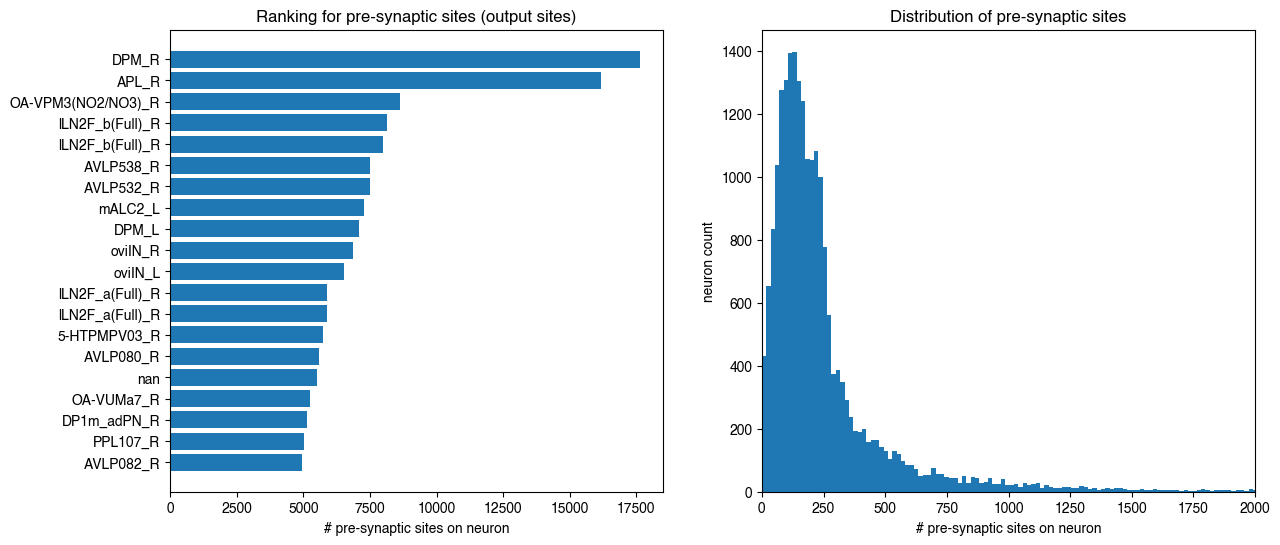

In [73]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_pre_sites.head(nn)))
performance = neurons_pre_sites['pre'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=neurons_pre_sites['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# pre-synaptic sites on neuron')
ax[0].set_title('Ranking for pre-synaptic sites (output sites)')

ax[1].hist(neurons_pre_sites['pre'],bins=1000)
ax[1].set_xlabel('# pre-synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of pre-synaptic sites')
ax[1].set_xlim(0,2000)

# put an arrow where oviIN is
ax[1].arrow(neurons_pre_sites[neurons_pre_sites['bodyId']==oviINr_bodyID]['pre'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_pre_sites[neurons_pre_sites['bodyId']==oviINr_bodyID]['pre'].values[0], 250), color='green')

plt.show()

### Ranking for post-syn sites

We observe that oviIN has the 13th most numerous post-synaptic sites. APL has the most, DPM has the 2nd most, lLN2F_bs have 8th and 10th most. 

In [74]:
neurons_post_sites = syn_neurons.sort_values(by='post',ascending=False,ignore_index=True)
neurons_post_sites.loc[neurons_post_sites['bodyId'] == oviINr_bodyID]

,bodyId,instance,pre,post
12,423101189,oviIN_R,6863,23029


In [77]:
neurons_post_sites.head(n=15)

,bodyId,instance,pre,post
0,425790257,APL_R,16190,127151
1,5813105172,DPM_R,17628,77269
2,612371421,MBON01(y5B'2a)_R,2208,32544
3,425276848,DPM_L,7088,30007
4,673509195,MBON01(y5B'2a)_L,2205,29244
5,5813039148,PVLP011_R,4693,28662
6,424767514,MBON11(y1pedc>a/B)_R,1646,27642
7,1640909284,lLN2F_b(Full)_R,7998,27355
8,799586652,MBON05(y4>y1y2)(AVM07)_L,1565,27110
9,5813024698,lLN2F_b(Full)_R,8152,26039


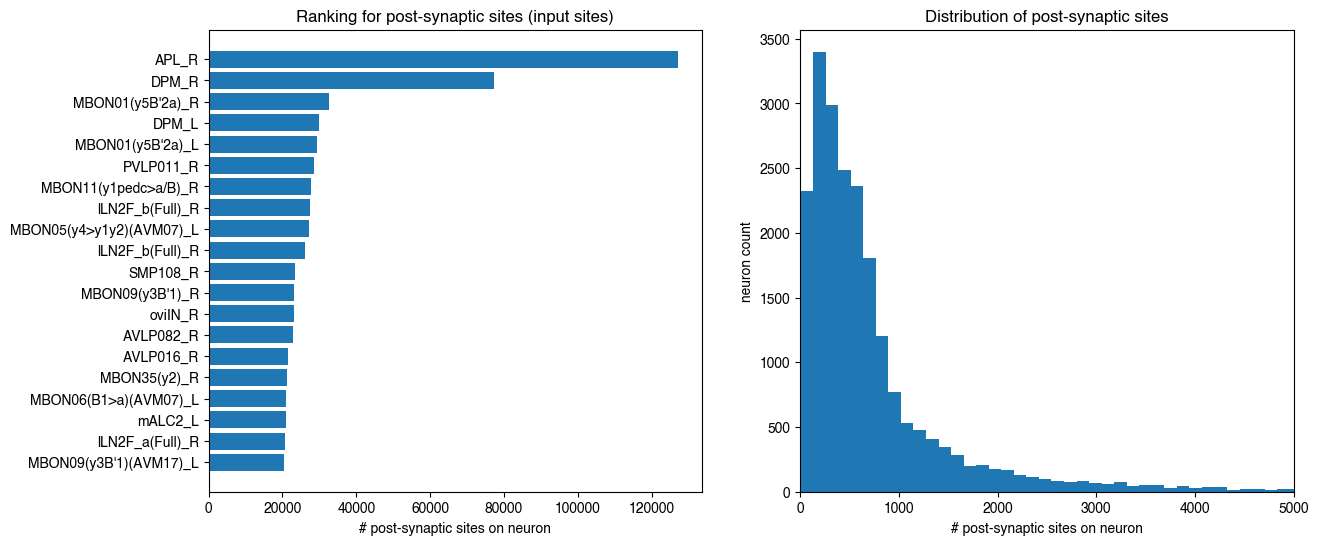

In [78]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_post_sites.head(nn)))
performance = neurons_post_sites['post'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=neurons_post_sites['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# post-synaptic sites on neuron')
ax[0].set_title('Ranking for post-synaptic sites (input sites)')

ax[1].hist(neurons_post_sites['post'],bins=1000)
ax[1].set_xlabel('# post-synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of post-synaptic sites')
ax[1].set_xlim(0,5000)

plt.show()

### Ranking for total synaptic sites
Note that there are far fewer pre sites than post sites for most neurons because of polyadic synapses. This count totals the pre and post sites on a given neuron's body, and given the disparity between the counts, this may closely follow the trend of post sites.

In [101]:
# create a new column to add up all the pre and post site for each neuron
syn_neurons['total_syn_sites'] = syn_neurons.loc[:, ('pre', 'post')].sum(axis=1)
syn_neurons = syn_neurons.sort_values(by='total_syn_sites',ascending=False,ignore_index=True)
syn_neurons

,bodyId,instance,pre,post,total_syn_sites
0,425790257,APL_R,16190,127151,143341
1,5813105172,DPM_R,17628,77269,94897
2,425276848,DPM_L,7088,30007,37095
3,1640909284,lLN2F_b(Full)_R,7998,27355,35353
4,612371421,MBON01(y5B'2a)_R,2208,32544,34752
...,...,...,...,...,...
21734,1409604476,LC20,8,10,18
21735,1077083999,MC61,10,6,16
21736,911815444,OCG09,2,10,12
21737,1003655362,OCG09,1,2,3


In [102]:
syn_neurons['total_syn_sites'].describe()

count     21739.000000
mean       1148.036478
std        2159.702159
min           2.000000
25%         371.000000
50%         685.000000
75%        1140.000000
max      143341.000000
Name: total_syn_sites, dtype: float64

In [103]:
syn_neurons.loc[syn_neurons['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post,total_syn_sites
8,423101189,oviIN_R,6863,23029,29892


oviIN has the 9th most number of total synaptic sites on its body. This may include synaptic sites that are unpartnered or not functional since it is the raw count of sites.
APL has the most, DPMs are 2nd and 3rd, and lLN2F_bs are 4th and 6th.

In [104]:
syn_neurons.head(n=10)

,bodyId,instance,pre,post,total_syn_sites
0,425790257,APL_R,16190,127151,143341
1,5813105172,DPM_R,17628,77269,94897
2,425276848,DPM_L,7088,30007,37095
3,1640909284,lLN2F_b(Full)_R,7998,27355,35353
4,612371421,MBON01(y5B'2a)_R,2208,32544,34752
5,5813024698,lLN2F_b(Full)_R,8152,26039,34191
6,5813039148,PVLP011_R,4693,28662,33355
7,673509195,MBON01(y5B'2a)_L,2205,29244,31449
8,423101189,oviIN_R,6863,23029,29892
9,424767514,MBON11(y1pedc>a/B)_R,1646,27642,29288


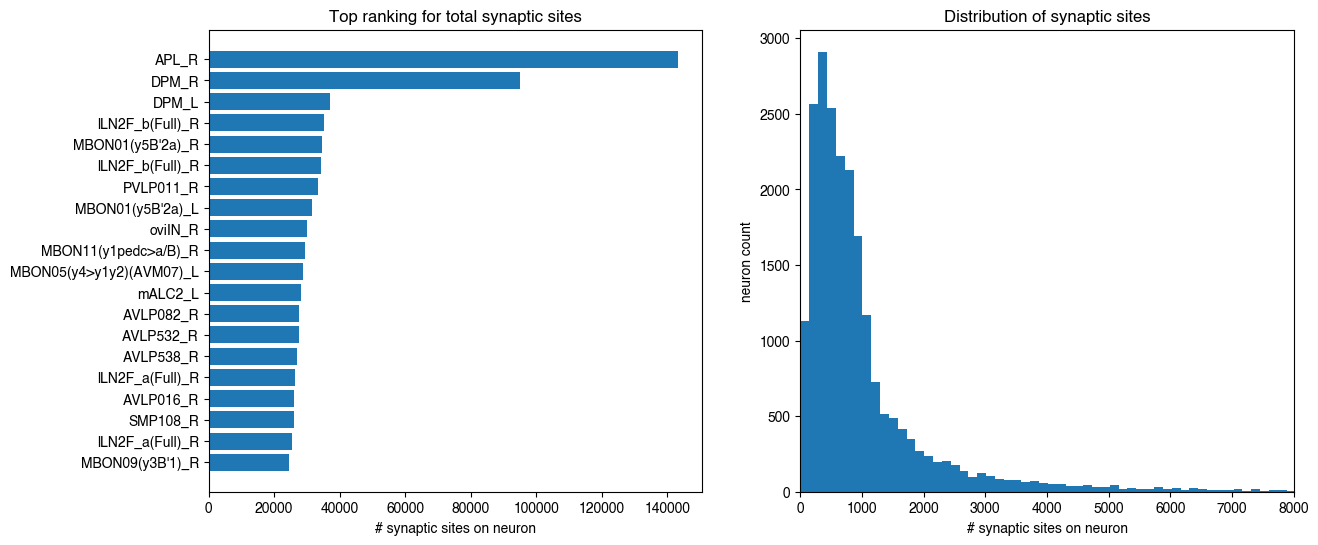

In [105]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(syn_neurons.head(nn)))
performance = syn_neurons['total_syn_sites'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=syn_neurons['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# synaptic sites on neuron')
ax[0].set_title('Top ranking for total synaptic sites')

ax[1].hist(syn_neurons['total_syn_sites'],bins=1000)
ax[1].set_xlabel('# synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of synaptic sites')
ax[1].set_xlim(0,8000)

#plt.savefig('figures/syn_sites_rank_hbar_hist.pdf', format='pdf')
plt.show()

Following is a figure of trends of Total synaptic sites but stacked by pre and post.

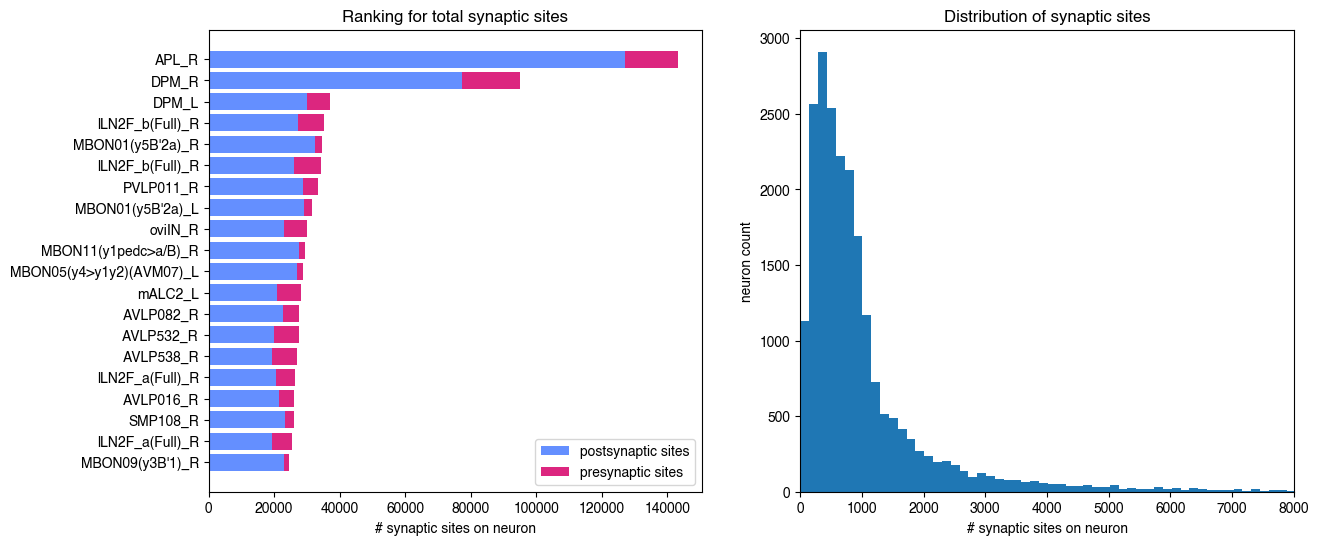

In [106]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(syn_neurons.head(nn)))
performance = syn_neurons['total_syn_sites'].head(nn)
pres = syn_neurons['pre'].head(nn)
posts = syn_neurons['post'].head(nn)

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

#ax[0].barh(y_pos, performance, align='center')
ax[0].barh(y_pos, posts, align='center', color=colors[0])
ax[0].barh(y_pos, pres, align='center', left=posts, color=colors[1])
ax[0].set_yticks(y_pos, labels=syn_neurons['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# synaptic sites on neuron')
ax[0].set_title('Ranking for total synaptic sites')
ax[0].legend(['postsynaptic sites','presynaptic sites'])

ax[1].hist(syn_neurons['total_syn_sites'],bins=1000)
ax[1].set_xlabel('# synaptic sites on neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of synaptic sites')
ax[1].set_xlim(0,8000)

# plt.savefig('figures/syn_sites_rank_hbar_hist_stackd.pdf', format='pdf')
plt.show()

Below, We compute the number of synaptic sites divided by each neurons size to study the density of synaptic sites for the big players. oviIN is not at all impressive in this regard, coming in at 2123rd.

In [107]:
# merge size and synapse dataframes so that I can normalize the synapse counts by size
syn_size_neurons = pd.merge(syn_neurons,size_neurons,on=['bodyId','instance'])
syn_size_neurons

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius
0,425790257,APL_R,16190,127151,143341,23360457066,900.1
1,5813105172,DPM_R,17628,77269,94897,15191654896,681.0
2,425276848,DPM_L,7088,30007,37095,6483095365,386.0
3,1640909284,lLN2F_b(Full)_R,7998,27355,35353,9656560959,741.5
4,612371421,MBON01(y5B'2a)_R,2208,32544,34752,6839504360,446.5
...,...,...,...,...,...,...,...
21734,1409604476,LC20,8,10,18,24007823,NaN
21735,1077083999,MC61,10,6,16,28198922,NaN
21736,911815444,OCG09,2,10,12,203180533,236.0
21737,1003655362,OCG09,1,2,3,144112634,291.0


In [108]:
# synapse density = total synapse sites / size
syn_size_neurons['syn_density'] = syn_size_neurons['total_syn_sites']/syn_size_neurons['size']
syn_size_neurons = syn_size_neurons.sort_values(by='syn_density',ascending=False,ignore_index=True)

In [109]:
syn_size_neurons.head(n=20)

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
0,364217037,NaN,83,2305,2388,111324878,NaN,0.000021
1,5813067721,MBON14(a3)_L,21,2180,2201,122772402,NaN,0.000018
2,394225044,MBON14(a3)_L,187,5172,5359,359288547,NaN,0.000015
3,1234386037,MBON07(a1)_R,512,15487,15999,1466363330,356.5,0.000011
4,733036127,MBON07(a1)_R,474,15519,15993,1520161953,292.5,0.000011
5,1016835041,MBON09(y3B'1)(AVM17)_L,1291,20281,21572,2083130629,NaN,0.000010
6,1048215779,MBON09(y3B'1)(AVM17)_L,1451,20255,21706,2226046804,NaN,0.000010
7,5813068729,MBON14(a3)_R,738,14387,15125,1564887657,NaN,0.000010
8,5813087625,NaN,208,951,1159,126240451,NaN,0.000009
9,300972942,MBON14(a3)_R,543,13634,14177,1566415099,NaN,0.000009


In [110]:
syn_size_neurons.loc[syn_size_neurons['bodyId']==oviINr_bodyID]

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
2123,423101189,oviIN_R,6863,23029,29892,10033593370,NaN,0.000003


In [111]:
syn_size_neurons.loc[syn_size_neurons['instance']=='APL_R']

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
48,425790257,APL_R,16190,127151,143341,23360457066,900.1,0.000006


In [112]:
syn_size_neurons.loc[syn_size_neurons['instance']=='lLN2F_b(Full)_R']

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
955,1640909284,lLN2F_b(Full)_R,7998,27355,35353,9656560959,741.5,0.000004
1100,5813024698,lLN2F_b(Full)_R,8152,26039,34191,9671459921,741.5,0.000004


In [113]:
syn_size_neurons.loc[syn_size_neurons['instance']=='DPM_R']

,bodyId,instance,pre,post,total_syn_sites,size,somaRadius,syn_density
39,5813105172,DPM_R,17628,77269,94897,15191654896,681.0,0.000006


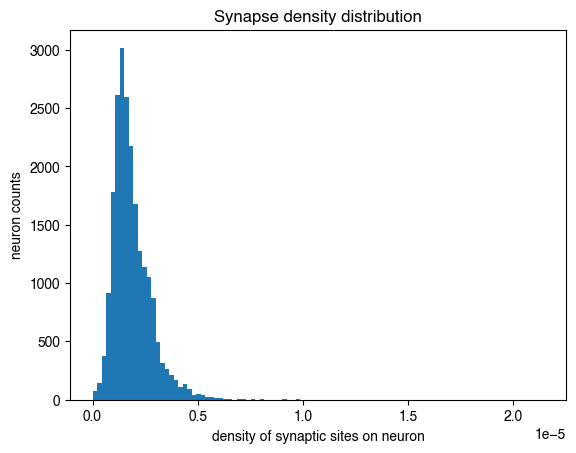

In [114]:
fig, ax = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
ax.hist(syn_size_neurons['syn_density'], bins=100)

ax.set_title('Synapse density distribution')
ax.set_xlabel('density of synaptic sites on neuron')
ax.set_ylabel('neuron counts')

plt.show()

## Synaptic weights
Instead of using the pre and post sites on the neurons body,We study the connection weights.

In [115]:
synweight_neurons = all_neurons[['bodyId','type','instance','input_weights','output_weights','total_weights']].copy()
synweight_neurons

,bodyId,type,instance,input_weights,output_weights,total_weights
0,200326126,CL141,CL141_L,987.0,1262.0,2249.0
1,202916528,FS4C,FS4C(FQ12)_C4_R,389.0,430.0,819.0
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R,336.0,231.0,567.0
3,203253253,SMP505,SMP505(PDM22)_L,2926.0,1100.0,4026.0
4,203257652,FS4C,FS4C(FQ12)_C6_R,248.0,262.0,510.0
...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,578.0,633.0,1211.0
21735,7112615127,AVLP335,AVLP335_R,521.0,475.0,996.0
21736,7112617294,AVLP331,AVLP331_R,605.0,417.0,1022.0
21737,7112622044,LAL137,LAL137(PVL05)_L,1947.0,4173.0,6120.0


### Ranking for input weights
We observe that oviIN_R ranks 13th for the amount of input weights it gets from presynaptic neurons.

In [116]:
neurons_inweights = synweight_neurons.sort_values(by='input_weights',ascending=False,ignore_index=True)
neurons_inweights.loc[neurons_inweights['bodyId']==oviINr_bodyID]

,bodyId,type,instance,input_weights,output_weights,total_weights
12,423101189,oviIN,oviIN_R,21624.0,29274.0,50898.0


In [118]:
neurons_inweights.head(n=15)

,bodyId,type,instance,input_weights,output_weights,total_weights
0,425790257,APL,APL_R,121329.0,108759.0,230088.0
1,5813105172,DPM,DPM_R,73542.0,48492.0,122034.0
2,612371421,MBON01,MBON01(y5B'2a)_R,31290.0,9018.0,40308.0
3,425276848,DPM,DPM_L,28391.0,21194.0,49585.0
4,673509195,MBON01,MBON01(y5B'2a)_L,27552.0,6344.0,33896.0
5,5813039148,PVLP011,PVLP011_R,27258.0,23701.0,50959.0
6,424767514,MBON11,MBON11(y1pedc>a/B)_R,26485.0,5684.0,32169.0
7,1640909284,lLN2F_b,lLN2F_b(Full)_R,26084.0,28323.0,54407.0
8,799586652,MBON05,MBON05(y4>y1y2)(AVM07)_L,25714.0,6046.0,31760.0
9,5813024698,lLN2F_b,lLN2F_b(Full)_R,24806.0,28755.0,53561.0


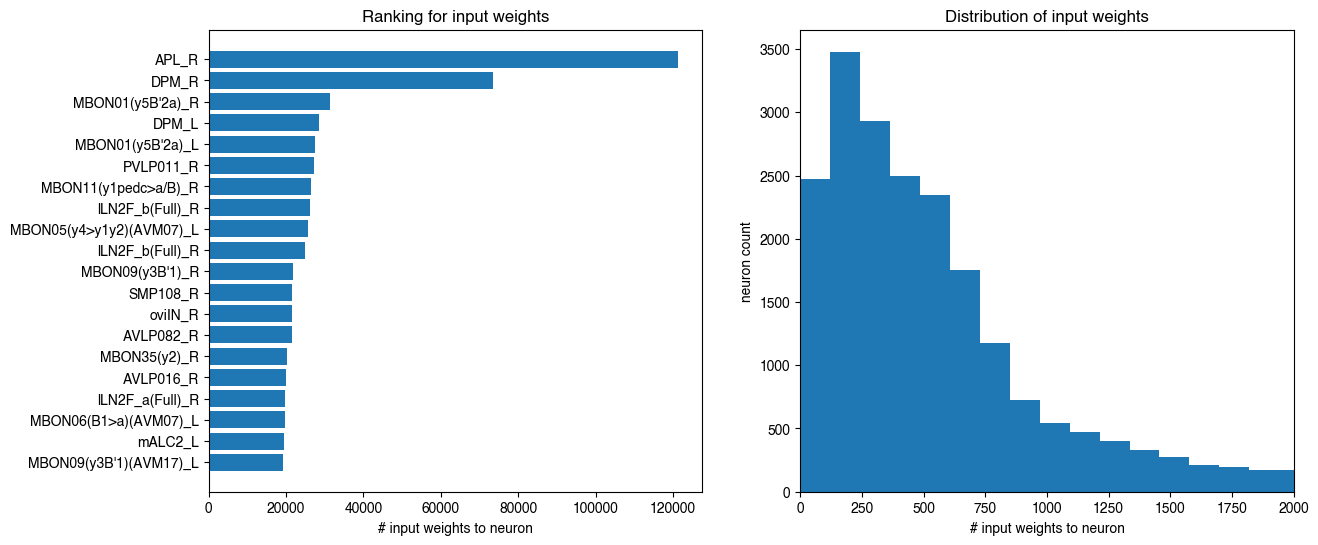

In [119]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_inweights.head(nn)))
performance = neurons_inweights['input_weights'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=neurons_inweights['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# input weights to neuron')
ax[0].set_title('Ranking for input weights')

ax[1].hist(neurons_inweights['input_weights'],bins=1000)
ax[1].set_xlabel('# input weights to neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of input weights')
ax[1].set_xlim(0,2000)

# put an arrow where oviIN is
ax[1].arrow(neurons_inweights[neurons_inweights['bodyId']==oviINr_bodyID]['input_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_inweights[neurons_inweights['bodyId']==oviINr_bodyID]['input_weights'].values[0], 250), color='green')

plt.show()

### Ranking for output weights
We observe that oviIN ranks 3rd for output weights which is very high. I'm kind of surprised. oviIN might be more interesting for who and how many other neurons it talks to. 

In [120]:
neurons_outweights = synweight_neurons.sort_values(by='output_weights',ascending=False,ignore_index=True)
neurons_outweights.loc[neurons_outweights['bodyId']==oviINr_bodyID]

,bodyId,type,instance,input_weights,output_weights,total_weights
2,423101189,oviIN,oviIN_R,21624.0,29274.0,50898.0


In [121]:
neurons_outweights.head(n=15)

,bodyId,type,instance,input_weights,output_weights,total_weights
0,425790257,APL,APL_R,121329.0,108759.0,230088.0
1,5813105172,DPM,DPM_R,73542.0,48492.0,122034.0
2,423101189,oviIN,oviIN_R,21624.0,29274.0,50898.0
3,5813024698,lLN2F_b,lLN2F_b(Full)_R,24806.0,28755.0,53561.0
4,1640909284,lLN2F_b,lLN2F_b(Full)_R,26084.0,28323.0,54407.0
5,485934965,oviIN,oviIN_L,15007.0,24806.0,39813.0
6,5813039148,PVLP011,PVLP011_R,27258.0,23701.0,50959.0
7,329566174,OA-VPM3,OA-VPM3(NO2/NO3)_R,9315.0,22467.0,31782.0
8,425276848,DPM,DPM_L,28391.0,21194.0,49585.0
9,5901218894,lLN2F_a,lLN2F_a(Full)_R,19713.0,18308.0,38021.0


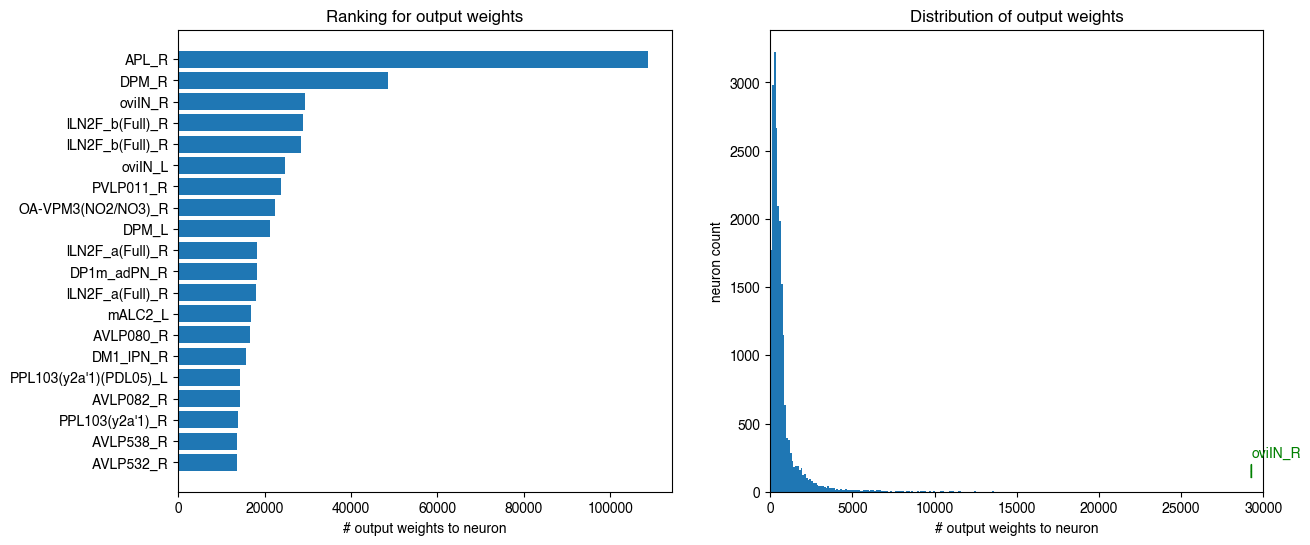

In [122]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_outweights.head(nn)))
performance = neurons_outweights['output_weights'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=neurons_outweights['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('# output weights to neuron')
ax[0].set_title('Ranking for output weights')

ax[1].hist(neurons_outweights['output_weights'],bins=1000)
ax[1].set_xlabel('# output weights to neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of output weights')
ax[1].set_xlim(0,30000)

# put an arrow where oviIN is
ax[1].arrow(neurons_outweights[neurons_outweights['bodyId']==oviINr_bodyID]['output_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_outweights[neurons_outweights['bodyId']==oviINr_bodyID]['output_weights'].values[0], 250), color='green')

plt.show()

### Ranking for total weights
We observe that oviIN ranks 6th for the total amount of synaptic weights.

In [123]:
neurons_totweights = synweight_neurons.sort_values(by='total_weights',ascending=False,ignore_index=True)
neurons_totweights.loc[neurons_totweights['bodyId']==oviINr_bodyID]

,bodyId,type,instance,input_weights,output_weights,total_weights
5,423101189,oviIN,oviIN_R,21624.0,29274.0,50898.0


In [125]:
neurons_totweights.head(n=15)

,bodyId,type,instance,input_weights,output_weights,total_weights
0,425790257,APL,APL_R,121329.0,108759.0,230088.0
1,5813105172,DPM,DPM_R,73542.0,48492.0,122034.0
2,1640909284,lLN2F_b,lLN2F_b(Full)_R,26084.0,28323.0,54407.0
3,5813024698,lLN2F_b,lLN2F_b(Full)_R,24806.0,28755.0,53561.0
4,5813039148,PVLP011,PVLP011_R,27258.0,23701.0,50959.0
5,423101189,oviIN,oviIN_R,21624.0,29274.0,50898.0
6,425276848,DPM,DPM_L,28391.0,21194.0,49585.0
7,612371421,MBON01,MBON01(y5B'2a)_R,31290.0,9018.0,40308.0
8,485934965,oviIN,oviIN_L,15007.0,24806.0,39813.0
9,5901218894,lLN2F_a,lLN2F_a(Full)_R,19713.0,18308.0,38021.0


In [126]:
neurons_totweights['total_weights'].describe()

count     21739.000000
mean       1565.121027
std        2988.120949
min           2.000000
25%         502.000000
50%         936.000000
75%        1584.000000
max      230088.000000
Name: total_weights, dtype: float64

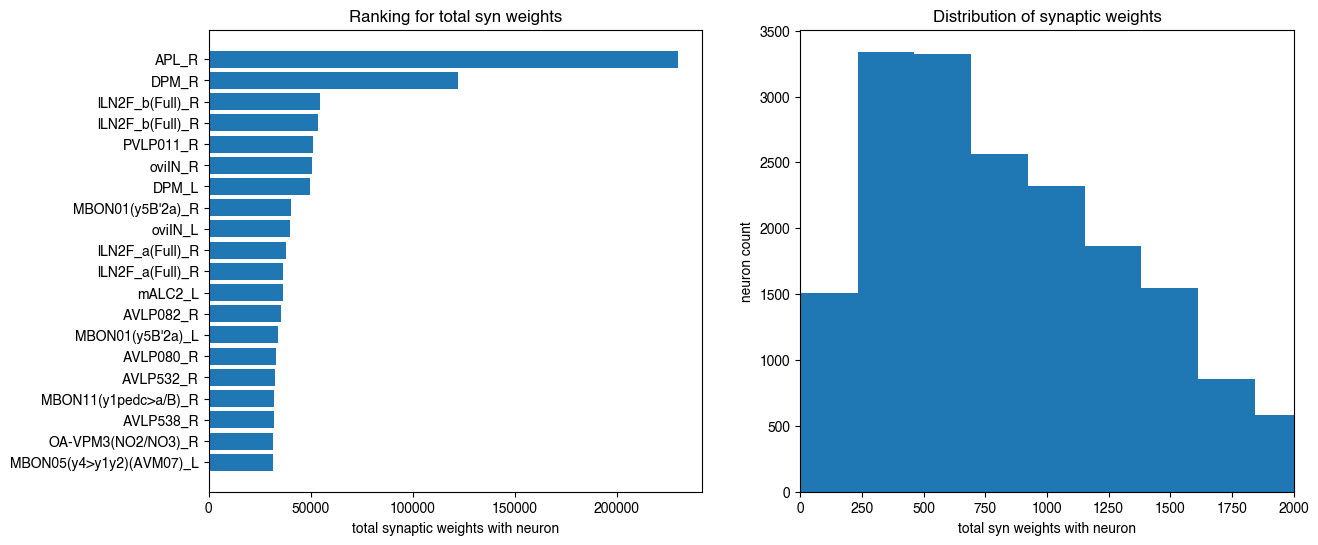

In [127]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_totweights.head(nn)))
performance = neurons_totweights['total_weights'].head(nn)

ax[0].barh(y_pos, performance, align='center')
ax[0].set_yticks(y_pos, labels=neurons_totweights['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('total synaptic weights with neuron')
ax[0].set_title('Ranking for total syn weights')

ax[1].hist(neurons_totweights['total_weights'],bins=1000)
ax[1].set_xlabel('total syn weights with neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of synaptic weights')
ax[1].set_xlim(0,2000)

# put an arrow where oviIN is
ax[1].arrow(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 250), color='green')

plt.show()

Following is a stacked bar plot that separates input and output weights.

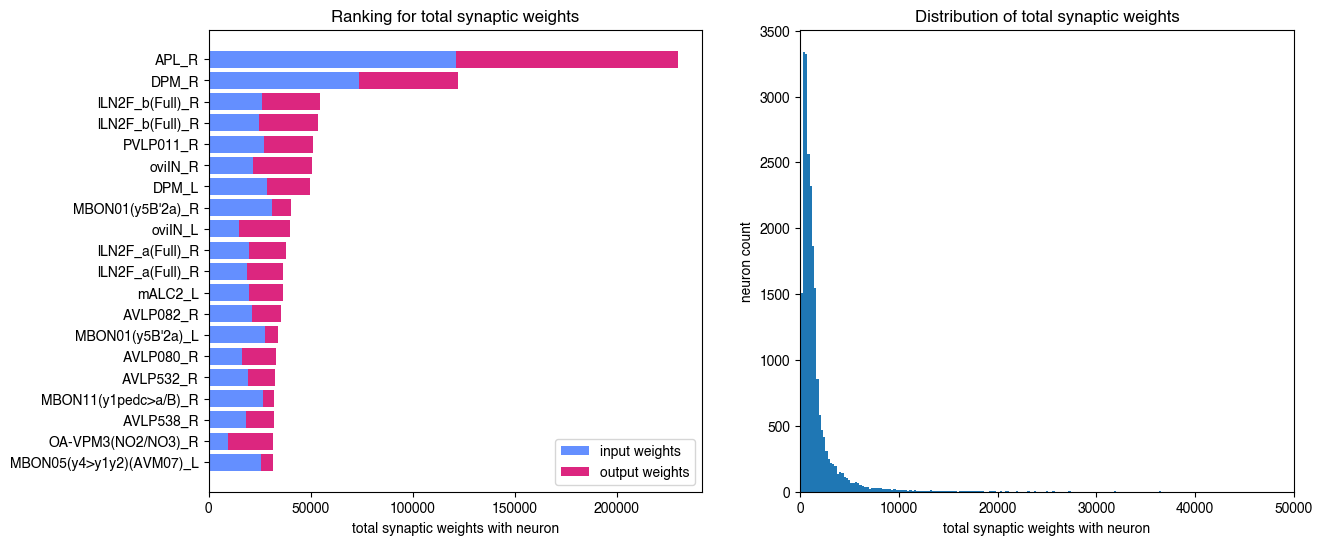

In [129]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

nn = 20

# grab the data
y_pos = np.arange(len(neurons_totweights.head(nn)))
inweights = neurons_totweights['input_weights'].head(nn)
outweights = neurons_totweights['output_weights'].head(nn)

# change the color of the bars
colors = ['#648FFF','#DC267F','#FB9004']

ax[0].barh(y_pos, inweights, align='center', color=colors[0])
ax[0].barh(y_pos, outweights, align='center', left=inweights, color=colors[1])
ax[0].set_yticks(y_pos, labels=neurons_totweights['instance'].head(nn))
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_xlabel('total synaptic weights with neuron')
ax[0].set_title('Ranking for total synaptic weights')
ax[0].legend(['input weights','output weights'])

ax[1].hist(neurons_totweights['total_weights'],bins=1000)
ax[1].set_xlabel('total synaptic weights with neuron')
ax[1].set_ylabel('neuron count')
ax[1].set_title('Distribution of total synaptic weights')
ax[1].set_xlim(0,50000)

# put an arrow where oviIN is
ax[1].arrow(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 200, 0, -50, head_width=10, head_length=50, ec='green')
ax[1].annotate('oviIN_R', xy=(neurons_totweights[neurons_totweights['bodyId']==oviINr_bodyID]['total_weights'].values[0], 250), color='green')

# plt.savefig('figures/syn_weights_rank_hbar_hist_stackd.pdf', format='pdf')
plt.show()

# Neuropils
We study the ranking for oviIN in terms of the number of neuropils it makes (pre and post synaptic) connections. 

In [130]:
all_neurons_rois = df[['bodyId','instance','type','inputRois','outputRois']].copy()
all_neurons_rois.dtypes

bodyId         int64
instance      object
type          object
inputRois     object
outputRois    object
dtype: object

In [133]:

# fetching primary ROIs in the full brain
prim_rois = pd.DataFrame(fetch_primary_rois(),columns=['roi'])

In [134]:
prim_rois

,roi
0,AB(L)
1,AB(R)
2,AL(L)
3,AL(R)
4,AME(R)
...,...
58,b'L(R)
59,bL(L)
60,bL(R)
61,gL(L)


In [135]:
# I guess I have to initialize this dataframe column
all_neurons_rois['n_tot_neuropils'] = 0
all_neurons_rois['n_in_neuropils'] = 0
all_neurons_rois['n_out_neuropils'] = 0

# loop through all the neurons and count up the number of unique primary neuropils they make connections with
for i, row in all_neurons_rois.iterrows():
  # obtain total unique neuropils for each neuron
  #in_out_rois_i = row.inputRois.strip("[]").replace("'",'').replace(" ",'').split(',') + row.outputRois.strip("[]").replace("'",'').replace(" ",'').split(',')
  #unique_rois_i = list(set(prim_rois['roi'].tolist()) & set(in_out_rois_i))
  unique_rois_i = list(set(prim_rois['roi'].tolist()) & set(row.inputRois+row.outputRois))
  all_neurons_rois['n_tot_neuropils'][i] = len(unique_rois_i)

  # obtain unique input neuropils for each neuron
  unique_in_rois_i = list(set(prim_rois['roi'].tolist()) & set(row.inputRois))
  all_neurons_rois['n_in_neuropils'][i] = len(unique_in_rois_i)

  # obtain unique output neuropils for each neuron
  unique_out_rois_i = list(set(prim_rois['roi'].tolist()) & set(row.outputRois))
  all_neurons_rois['n_out_neuropils'][i] = len(unique_out_rois_i)

all_neurons_rois['n_tot_neuropils'] = all_neurons_rois['n_tot_neuropils'].astype(int)
all_neurons_rois['n_in_neuropils'] = all_neurons_rois['n_in_neuropils'].astype(int)
all_neurons_rois['n_out_neuropils'] = all_neurons_rois['n_out_neuropils'].astype(int)
all_neurons_rois

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
0,200326126,CL141_L,CL141,"[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","[AVLP(R), ICL(R), INP, LH(R), MB(+ACA)(R), PLP...",7,7,6
1,202916528,FS4C(FQ12)_C4_R,FS4C,"[CX, FB, FB-column3, FBl1, FBl2, FBl3, FBl4, F...","[CX, FB, FBl7, SMP(L), SNP(L)]",3,3,2
2,203253072,FS4A(AB)(FQ12)_C3_R,FS4A,"[AB(R), CRE(-RUB)(L), CRE(L), CX, FB, FB-colum...","[AB(R), CX, FB, FB-column3, FBl1, FBl7, FBl8, ...",5,5,3
3,203253253,SMP505(PDM22)_L,SMP505,"[ATL(L), CRE(-RUB)(L), CRE(L), ICL(L), INP, SC...","[SIP(L), SIP(R), SLP(R), SMP(L), SMP(R), SNP(L...",9,9,5
4,203257652,FS4C(FQ12)_C6_R,FS4C,"[CX, FB, FBl1, FBl2, FBl3, FBl4, FBl5, FBl6, F...","[SIP(L), SMP(L), SNP(L)]",3,3,2
...,...,...,...,...,...,...,...,...
21734,7112579856,LC20,LC20,"[LO(R), OL(R), PLP(R), VLNP(R)]","[LO(R), OL(R), PLP(R), VLNP(R)]",2,2,2
21735,7112615127,AVLP335_R,AVLP335,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]",2,2,2
21736,7112617294,AVLP331_R,AVLP331,"[AVLP(R), PVLP(R), VLNP(R)]","[AVLP(R), PVLP(R), VLNP(R)]",2,2,2
21737,7112622044,LAL137(PVL05)_L,LAL137,"[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...","[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...",12,11,10


In [137]:
all_neurons_rois = all_neurons_rois.sort_values(by='n_tot_neuropils',ascending=False,ignore_index=True)
all_neurons_rois.head(20)

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
0,1418618235,SIFa(PDM34),SIFa,"[AL(R), AL-D(R), AL-DA1(R), AL-DC1(R), AL-DC3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DC1(...",40,34,39
1,329566174,OA-VPM3(NO2/NO3)_R,OA-VPM3,"[AL(R), AL-VP2(R), ATL(L), ATL(R), AVLP(R), BU...","[AL(R), AL-VP2(R), AOTU(R), ATL(L), ATL(R), AV...",33,30,31
2,1072063538,DNp27_R,DNp27,"[AME(R), AOT(R), AOTU(R), ATL(L), ATL(R), AVLP...","[AME(R), AOT(R), AOTU(R), ATL(L), ATL(R), AVLP...",31,28,28
3,326253554,SMP454_R,SMP454,"[ATL(R), AVLP(R), CAN(R), CRE(-ROB,-RUB)(R), C...","[AOTU(R), AVLP(R), CRE(-ROB,-RUB)(R), CRE(-RUB...",29,28,16
4,5813050455,DNp32_R,DNp32,"[AL(L), AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), ...","[AL(L), AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), ...",29,27,29
5,791527493,5-HTPMPV03_L,5-HTPMPV03,"[AME(R), AMMC, ATL(L), ATL(R), CAN(R), EPA(R),...","[AME(R), AMMC, ATL(L), ATL(R), CAN(R), EPA(R),...",28,27,28
6,5813054053,OA-ASM3_R,OA-ASM3,"[AL(R), AVLP(R), CX, EPA(L), EPA(R), FB, FBl8,...","[AL(R), AVLP(R), EPA(L), EPA(R), GC, GNG, GOR(...",28,28,25
7,669325882,5-HTPMPV03_R,5-HTPMPV03,"[AMMC, ATL(L), ATL(R), CAN(R), EPA(R), GNG, GO...","[AMMC, ATL(L), ATL(R), CAN(R), EPA(R), GNG, GO...",28,27,27
8,1501392572,PS088_R,PS088,"[AMMC, AOTU(R), ATL(L), ATL(R), CAN(R), EPA(L)...","[AMMC, AOTU(R), ATL(L), ATL(R), CAN(R), EPA(L)...",28,28,26
9,1534270924,VES041_R,VES041,"[AOTU(R), ATL(L), ATL(R), CAN(R), CRE(-ROB,-RU...","[AOTU(R), ATL(L), ATL(R), CRE(-ROB,-RUB)(R), C...",28,28,21


In [138]:
all_neurons_rois.loc[all_neurons_rois['bodyId']==oviINr_bodyID]

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
379,423101189,oviIN_R,oviIN,"[ATL(R), CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(...","[CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",14,14,12


In [139]:
set(all_neurons_rois.loc[all_neurons_rois['bodyId']==oviINr_bodyID].inputRois.values[0]) & set(prim_rois['roi'].tolist())

{'ATL(R)',
 'CAN(R)',
 'CRE(L)',
 'CRE(R)',
 'FLA(R)',
 'GOR(R)',
 'IB',
 'LAL(R)',
 'SIP(L)',
 'SIP(R)',
 'SMP(L)',
 'SMP(R)',
 'SPS(R)',
 'VES(R)'}

In [140]:
all_neurons_rois.loc[all_neurons_rois['type']=='oviIN']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
379,423101189,oviIN_R,oviIN,"[ATL(R), CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(...","[CAN(R), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",14,14,12
624,485934965,oviIN_L,oviIN,"[ATL(L), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...","[ATL(L), CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(...",12,12,12


oviINr ranks 404th for the number of neuropils it interacts with, but this doesn't mean much given that there are many neurons that interact with the same number of neuropils.

In [141]:
all_neurons_rois[400:410]

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
400,858458268,CL071_R,CL071,"[AVLP(R), GOR(L), GOR(R), IB, ICL(L), ICL(R), ...","[AVLP(R), GOR(L), GOR(R), IB, ICL(L), ICL(R), ...",14,14,14
401,5813078074,SMP585_R,SMP585,"[CRE(-ROB,-RUB)(R), CRE(R), FLA(R), GNG, GOR(L...","[GNG, GOR(R), IPS(R), SMP(R), SNP(R), VES(R), ...",14,14,5
402,914203527,PS123_R,PS123,"[ATL(L), ATL(R), CAN(R), GNG, GOR(L), GOR(R), ...","[IB, INP, IPS(R), SPS(L), SPS(R), VMNP]",14,14,4
403,5812981791,PPL108(PDL05)_L,PPL108,"[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...","[CRE(-ROB,-RUB)(R), CRE(-RUB)(L), CRE(L), CRE(...",14,12,13
404,1535791554,None,None,"[AVLP(R), CAN(R), EPA(R), GC, GNG, GOR(R), ICL...","[AVLP(R), CAN(R), EPA(R), GC, GNG, GOR(R), ICL...",14,14,14
405,1010713883,CL205_R,CL205,"[AOTU(R), CRE(-ROB,-RUB)(R), CRE(R), EPA(R), G...","[GOR(R), INP, SCL(R), SPS(R), VMNP]",14,14,3
406,1034664458,PS119(PDM16)_L,PS119,"[ATL(R), CAN(R), IB, ICL(L), ICL(R), INP, PENP...","[ICL(L), ICL(R), INP, SCL(L), SCL(R), SIP(R), ...",14,13,9
407,1161429278,PS250_R,PS250,"[CAN(R), EPA(L), EPA(R), GNG, IB, ICL(R), INP,...","[EPA(L), GNG, IB, ICL(R), INP, LAL(L), LX(L), ...",14,14,11
408,1014344148,AVLP151_R,AVLP151,"[AVLP(R), EPA(R), GNG, GOR(R), ICL(R), INP, IP...","[AVLP(R), EPA(R), GNG, GOR(R), ICL(R), INP, IP...",14,14,14
409,2222406094,VES035_R,VES035,"[AVLP(R), GOR(L), GOR(R), IB, ICL(R), INP, LAL...","[AVLP(R), GOR(L), IB, ICL(L), ICL(R), INP, LAL...",14,13,12


However, the vast majority of neurons interact with fewer than 10 neuropils, so oviIN is notable.

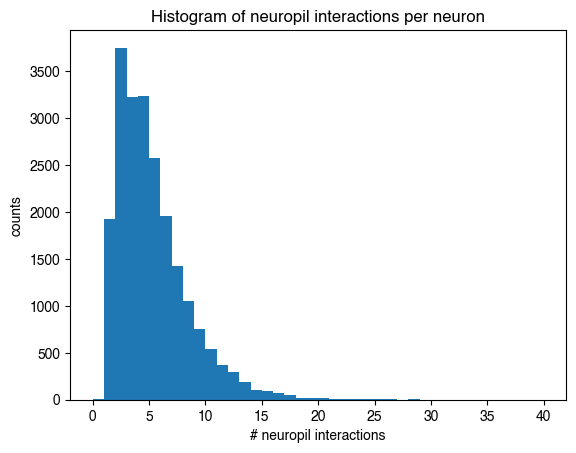

In [148]:
# histogram of neuropil interactions
plt.hist(all_neurons_rois['n_tot_neuropils'],bins=all_neurons_rois['n_tot_neuropils'].max())
plt.title("Histogram of neuropil interactions per neuron")
plt.xlabel("# neuropil interactions")
plt.ylabel("counts")
plt.show()

Meanwhile, APL interacts with 24 neuropils - which is much more than we expected. DPMs interact with 13 and 10, lLN2F_bs interact with 2 and 4. 

In [152]:
all_neurons_rois.loc[all_neurons_rois['type']=='APL']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
26,425790257,APL_R,APL,"[AL(R), AL-VP2(R), ATL(L), ATL(R), AVLP(R), CA...","[AL(R), AL-VP2(R), ATL(L), CA(R), CRE(-ROB,-RU...",24,24,18


In [153]:
all_neurons_rois.loc[all_neurons_rois['type']=='DPM']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
553,5813105172,DPM_R,DPM,"[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), ICL(R), I...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), ICL(R), I...",13,13,12
1356,425276848,DPM_L,DPM,"[CRE(-RUB)(L), CRE(L), INP, MB(+ACA)(R), MB(L)...","[CRE(-RUB)(L), CRE(L), INP, MB(+ACA)(R), MB(L)...",10,10,7


In [154]:
all_neurons_rois.loc[all_neurons_rois['type']=='lLN2F_b']

,bodyId,instance,type,inputRois,outputRois,n_tot_neuropils,n_in_neuropils,n_out_neuropils
9716,5813024698,lLN2F_b(Full)_R,lLN2F_b,"[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...",4,4,4
17837,1640909284,lLN2F_b(Full)_R,lLN2F_b,"[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...","[AL(R), AL-D(R), AL-DA1(R), AL-DA2(R), AL-DA3(...",2,2,2


In [155]:
# summary stats
all_neurons_rois['n_tot_neuropils'].describe()

count    21739.000000
mean         4.809375
std          3.239753
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         40.000000
Name: n_tot_neuropils, dtype: float64

On average, a neuron in the Hemibrain connects to 4.7 neuropils.